In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Preprocess

In [2]:
df = pd.read_csv('Yettel Data Scientist Assignment Data Set.txt', sep=';', encoding='latin1')
df.head()

DAY_ID_ENCR CUST_LEVEL GENDER_ENCR R_AGE_Y INSTALMENT_IND INSTAL_CNT  \
0  2016. 05. 22.        LOW         200      19              N          ?   
1  2016. 05. 12.     MEDIUM         200      24              Y         17   
2  2015. 11. 20.     MEDIUM         100      29              N          ?   
3  2016. 05. 07.     LOWEST         100      58              Y         22   
4  2016. 04. 07.     LOWEST         100      31              Y          6   

             PRODUCT_NAME MANUFACTURER_NAME_EN OPERATING_SYSTEM  \
0      Huawei Ascend Y560               Huawei          Android   
1  Samsung Galaxy S7 Edge              Samsung          Android   
2            Lenovo A6000               Lenovo          Android   
3          Apple iPhone5S                Apple              iOS   
4       Samsung Galaxy J5              Samsung          Android   

  HANDSET_FEATURE_CAT_DESC  ... SELLING_PRICE_AMT_ENCR UPFRONT_PYM_AMT_ENCR  \
0            Low-end smart  ...                   0,00                 0,00   
1            Premium smart  ...               21371,14              1187,29   
2             Medium smart  ...                   0,00                 0,00   
3            Premium smart  ...               11247,43                 0,00   
4             Medium smart  ...                5060,71               421,71   

  monthly_fee_ENCR TARIFF_LEVEL CHANNEL_CLASS  \
0           448,82     S Tariff       Virtual   
1           730,03     M Tariff      Physical   
2           730,03     M Tariff      Physical   
3           246,34    XS Tariff      Physical   
4           246,34    XS Tariff      Physical   

                     channel_group ADDRESS_COUNTY_ENCR OUTLET_COUNTY_ENCR  \
0                      Web Channel                  NQ                  ?   
1            Telenor Store Channel                  OX                 BW   
2            Telenor Store Channel                  SB                 SB   
3  Exclusive Partner Store Channel                  LZ                 LZ   
4  Exclusive Partner Store Channel                  FA                 RK   

  FRAUD_STATUS_6MONTH nopay_after_12month  
0                   N                   0  
1                   Y                   1  
2                   N                   0  
3                   N                   0  
4                   N                   0  

[5 rows x 21 columns]

In [3]:
df.replace('?', np.nan, inplace=True)

In [4]:
df.isnull().sum()

DAY_ID_ENCR                          0
CUST_LEVEL                           0
GENDER_ENCR                        174
R_AGE_Y                             67
INSTALMENT_IND                       0
INSTAL_CNT                       22569
PRODUCT_NAME                         0
MANUFACTURER_NAME_EN                 0
OPERATING_SYSTEM                  2843
HANDSET_FEATURE_CAT_DESC            33
MOVING_AVERAGE_PRICE_AMT_ENCR        0
SELLING_PRICE_AMT_ENCR               0
UPFRONT_PYM_AMT_ENCR                 0
monthly_fee_ENCR                     0
TARIFF_LEVEL                       275
CHANNEL_CLASS                        0
channel_group                        0
ADDRESS_COUNTY_ENCR                108
OUTLET_COUNTY_ENCR                1818
FRAUD_STATUS_6MONTH                  0
nopay_after_12month                  0
dtype: int64

In [5]:
#It seems that all virtual purchases do not have a specific country, so the buyer should be given
df.groupby("CHANNEL_CLASS")["OUTLET_COUNTY_ENCR"].apply(lambda x: x.isna().mean())

CHANNEL_CLASS
Physical    0.000784
Virtual     1.000000
Name: OUTLET_COUNTY_ENCR, dtype: float64

In [6]:
df.loc[df["OUTLET_COUNTY_ENCR"].isna() & (df["CHANNEL_CLASS"] == "Virtual"),"OUTLET_COUNTY_ENCR"] = df.loc[df["OUTLET_COUNTY_ENCR"].isna() & (df["CHANNEL_CLASS"] == "Virtual"),"ADDRESS_COUNTY_ENCR"]

In [7]:
#Where the customer did not request an installment, the installment time is nan, except for a few anomalies, where it should obviously be 0
df.groupby("INSTALMENT_IND")["INSTAL_CNT"].apply(lambda x: x.isna().mean())

INSTALMENT_IND
N    0.999592
Y    0.028176
Name: INSTAL_CNT, dtype: float64

In [8]:
df[(df["INSTALMENT_IND"] == "N") & (df["INSTAL_CNT"].notna())]["INSTAL_CNT"].unique()

array(['12', '22', '17', '11'], dtype=object)

In [9]:
df.loc[(df["INSTALMENT_IND"] == "N"), "INSTAL_CNT"] = 0

In [10]:
#Filling the obviously missing OS
OS = df.groupby("MANUFACTURER_NAME_EN")["OPERATING_SYSTEM"]

filteredOS = {
    man: os.dropna().unique()[0]
    for man, os in OS
    if os.isna().sum() > 0 and os.dropna().nunique() == 1
}

df.loc[
    df['MANUFACTURER_NAME_EN'].isin(filteredOS.keys()) & df['OPERATING_SYSTEM'].isna(),
    'OPERATING_SYSTEM'
] = df['MANUFACTURER_NAME_EN'].map(filteredOS)


In [11]:
missingModels = df[df['OPERATING_SYSTEM'].isna()]['PRODUCT_NAME'].unique()
print(missingModels)

['Samsung Galaxy J5' 'Samsung Galaxy Core Prime'
 'Samsung Galaxy Tab S2 9.7, white'
 'Nokia W.less Charging PillowDT-901Fatboy'
 'Samsung Galaxy Tab S2 8.0, black' 'Nokia 301.1' 'JBL Clip plus, grey'
 'Samsung Galaxy Trend 2 Lite' 'Samsung G928F'
 'LG HBS-750-es Bluetooth fülhallgató' 'Samsung Gear VR szemüveg'
 'Teleszkópos Bluetooth selfie bot' 'Nokia Lumia 635'
 'Samsung Galaxy S III' 'Samsung Galaxy Tab A 9.7, black'
 'Unknown Handset']


In [12]:
missingModels.shape[0]

16

In [13]:
#Filling the missing values based on the previous values, ​​where there is no previous information: NO_OS
product_os_map = {}
no_os_models = []

for model in missingModels:
    known_os = df[(df['PRODUCT_NAME'] == model) & (df['OPERATING_SYSTEM'].notna())]['OPERATING_SYSTEM']
    
    if not known_os.empty:
        product_os_map[model] = known_os.mode().iloc[0]
    else:
        no_os_models.append(model)

df.loc[df['PRODUCT_NAME'].isin(product_os_map.keys()) & df['OPERATING_SYSTEM'].isna(),'OPERATING_SYSTEM'] = df['PRODUCT_NAME'].map(product_os_map)

df.loc[df['PRODUCT_NAME'].isin(no_os_models) & df['OPERATING_SYSTEM'].isna(),'OPERATING_SYSTEM'] = "NO_OS"

print('missing OPERATING_SYSTEM:', df['OPERATING_SYSTEM'].isna().sum())

missing OPERATING_SYSTEM: 0


In [14]:
no_os_models

['Samsung Galaxy Tab S2 9.7, white',
 'Nokia W.less Charging PillowDT-901Fatboy',
 'Samsung Galaxy Tab S2 8.0, black',
 'JBL Clip plus, grey',
 'LG HBS-750-es Bluetooth fülhallgató',
 'Samsung Gear VR szemüveg',
 'Teleszkópos Bluetooth selfie bot',
 'Samsung Galaxy S III',
 'Samsung Galaxy Tab A 9.7, black',
 'Unknown Handset']

In [15]:
# There are a few models that dont have any information about the os type, I edit them
target_models = [
    'Samsung Galaxy Tab S2 9.7, white',
    'Samsung Galaxy Tab S2 8.0, black',
    'Samsung Galaxy S III',
    'Samsung Galaxy Tab A 9.7, black'
]

df.loc[(df['PRODUCT_NAME'].isin(target_models)),'OPERATING_SYSTEM'] = 'Android'

In [16]:
df['OPERATING_SYSTEM'].value_counts()

OPERATING_SYSTEM
Android          35465
iOS               3142
Windows Phone     2401
Proprietary        246
Symbian             33
ISA                 28
NO_OS               26
Name: count, dtype: int64

In [17]:
df[(df["OPERATING_SYSTEM"] == 'NO_OS')]

DAY_ID_ENCR CUST_LEVEL GENDER_ENCR R_AGE_Y INSTALMENT_IND INSTAL_CNT  \
1076   2015. 09. 10.     LOWEST         100      37              N          0   
2144   2015. 10. 21.     MEDIUM         200      22              N          0   
2367   2016. 07. 27.       HIGH         200      45              N          0   
4805   2016. 06. 30.     MEDIUM         100      42              N          0   
7114   2016. 07. 06.     MEDIUM         200      87              N          0   
8343   2016. 07. 14.     LOWEST         100      23              N          0   
8892   2015. 12. 06.       HIGH         200      19              N          0   
8964   2016. 07. 27.     MEDIUM         200      32              N          0   
9179   2016. 08. 29.        LOW         200      50              Y        NaN   
11424  2016. 07. 01.     MEDIUM         200      27              N          0   
12416  2016. 02. 19.       HIGH         200      47              N          0   
14033  2016. 08. 06.     MEDIUM         200      51              N          0   
14436  2016. 07. 22.     MEDIUM         200      30              N          0   
15268  2016. 08. 05.       HIGH         200      40              N          0   
15789  2016. 06. 03.       HIGH         200      39              N          0   
17342  2016. 01. 19.       HIGH         200      32              N          0   
18640  2016. 07. 26.     MEDIUM         100      67              N          0   
22055  2015. 12. 11.       HIGH         100      60              Y        NaN   
23908  2016. 01. 02.     MEDIUM         200      30              N          0   
24379  2016. 07. 10.     MEDIUM         100      26              N          0   
24714  2016. 07. 10.       HIGH         200      43              N          0   
25394  2016. 07. 07.     MEDIUM         200      19              N          0   
29551  2016. 02. 02.       HIGH         200      22              N          0   
36268  2016. 07. 09.       HIGH         200      34              N          0   
36847  2016. 07. 09.     MEDIUM         200      27              N          0   
38021  2015. 09. 18.       HIGH         200      20              N          0   

                                   PRODUCT_NAME MANUFACTURER_NAME_EN  \
1076   Nokia W.less Charging PillowDT-901Fatboy            Undefined   
2144   Nokia W.less Charging PillowDT-901Fatboy            Undefined   
2367                        JBL Clip plus, grey            Undefined   
4805                        JBL Clip plus, grey            Undefined   
7114                        JBL Clip plus, grey            Undefined   
8343                        JBL Clip plus, grey            Undefined   
8892        LG HBS-750-es Bluetooth fülhallgató            Undefined   
8964                        JBL Clip plus, grey            Undefined   
9179                   Samsung Gear VR szemüveg            Undefined   
11424                       JBL Clip plus, grey            Undefined   
12416          Teleszkópos Bluetooth selfie bot            Undefined   
14033                       JBL Clip plus, grey            Undefined   
14436                       JBL Clip plus, grey            Undefined   
15268                       JBL Clip plus, grey            Undefined   
15789                       JBL Clip plus, grey            Undefined   
17342          Teleszkópos Bluetooth selfie bot            Undefined   
18640                       JBL Clip plus, grey            Undefined   
22055                           Unknown Handset              Unknown   
23908          Teleszkópos Bluetooth selfie bot            Undefined   
24379                       JBL Clip plus, grey            Undefined   
24714                       JBL Clip plus, grey            Undefined   
25394                       JBL Clip plus, grey            Undefined   
29551          Teleszkópos Bluetooth selfie bot            Undefined   
36268                       JBL Clip plus, grey            Undefined   
36847                

In [18]:
df.isnull().sum()

DAY_ID_ENCR                        0
CUST_LEVEL                         0
GENDER_ENCR                      174
R_AGE_Y                           67
INSTALMENT_IND                     0
INSTAL_CNT                       544
PRODUCT_NAME                       0
MANUFACTURER_NAME_EN               0
OPERATING_SYSTEM                   0
HANDSET_FEATURE_CAT_DESC          33
MOVING_AVERAGE_PRICE_AMT_ENCR      0
SELLING_PRICE_AMT_ENCR             0
UPFRONT_PYM_AMT_ENCR               0
monthly_fee_ENCR                   0
TARIFF_LEVEL                     275
CHANNEL_CLASS                      0
channel_group                      0
ADDRESS_COUNTY_ENCR              108
OUTLET_COUNTY_ENCR                35
FRAUD_STATUS_6MONTH                0
nopay_after_12month                0
dtype: int64

In [19]:
df.duplicated().sum()

501

In [20]:
df.dropna(inplace=True)
df.drop_duplicates(inplace=True)

In [21]:
df.head()

DAY_ID_ENCR CUST_LEVEL GENDER_ENCR R_AGE_Y INSTALMENT_IND INSTAL_CNT  \
0  2016. 05. 22.        LOW         200      19              N          0   
1  2016. 05. 12.     MEDIUM         200      24              Y         17   
2  2015. 11. 20.     MEDIUM         100      29              N          0   
3  2016. 05. 07.     LOWEST         100      58              Y         22   
4  2016. 04. 07.     LOWEST         100      31              Y          6   

             PRODUCT_NAME MANUFACTURER_NAME_EN OPERATING_SYSTEM  \
0      Huawei Ascend Y560               Huawei          Android   
1  Samsung Galaxy S7 Edge              Samsung          Android   
2            Lenovo A6000               Lenovo          Android   
3          Apple iPhone5S                Apple              iOS   
4       Samsung Galaxy J5              Samsung          Android   

  HANDSET_FEATURE_CAT_DESC  ... SELLING_PRICE_AMT_ENCR UPFRONT_PYM_AMT_ENCR  \
0            Low-end smart  ...                   0,00                 0,00   
1            Premium smart  ...               21371,14              1187,29   
2             Medium smart  ...                   0,00                 0,00   
3            Premium smart  ...               11247,43                 0,00   
4             Medium smart  ...                5060,71               421,71   

  monthly_fee_ENCR TARIFF_LEVEL CHANNEL_CLASS  \
0           448,82     S Tariff       Virtual   
1           730,03     M Tariff      Physical   
2           730,03     M Tariff      Physical   
3           246,34    XS Tariff      Physical   
4           246,34    XS Tariff      Physical   

                     channel_group ADDRESS_COUNTY_ENCR OUTLET_COUNTY_ENCR  \
0                      Web Channel                  NQ                 NQ   
1            Telenor Store Channel                  OX                 BW   
2            Telenor Store Channel                  SB                 SB   
3  Exclusive Partner Store Channel                  LZ                 LZ   
4  Exclusive Partner Store Channel                  FA                 RK   

  FRAUD_STATUS_6MONTH nopay_after_12month  
0                   N                   0  
1                   Y                   1  
2                   N                   0  
3                   N                   0  
4                   N                   0  

[5 rows x 21 columns]

In [22]:
df["GENDER_ENCR"] = df["GENDER_ENCR"].replace({"100": 0, "200": 1})
df["INSTALMENT_IND"] = df["INSTALMENT_IND"].replace({"N": 0, "Y": 1})
df["FRAUD_STATUS_6MONTH"] = df["FRAUD_STATUS_6MONTH"].replace({"N": 0, "Y": 1})

C:\Users\gergo\AppData\Local\Temp\ipykernel_21044\1739417178.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["GENDER_ENCR"] = df["GENDER_ENCR"].replace({"100": 0, "200": 1})
C:\Users\gergo\AppData\Local\Temp\ipykernel_21044\1739417178.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["INSTALMENT_IND"] = df["INSTALMENT_IND"].replace({"N": 0, "Y": 1})
C:\Users\gergo\AppData\Local\Temp\ipykernel_21044\1739417178.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. T

Exploratory Data Analysis

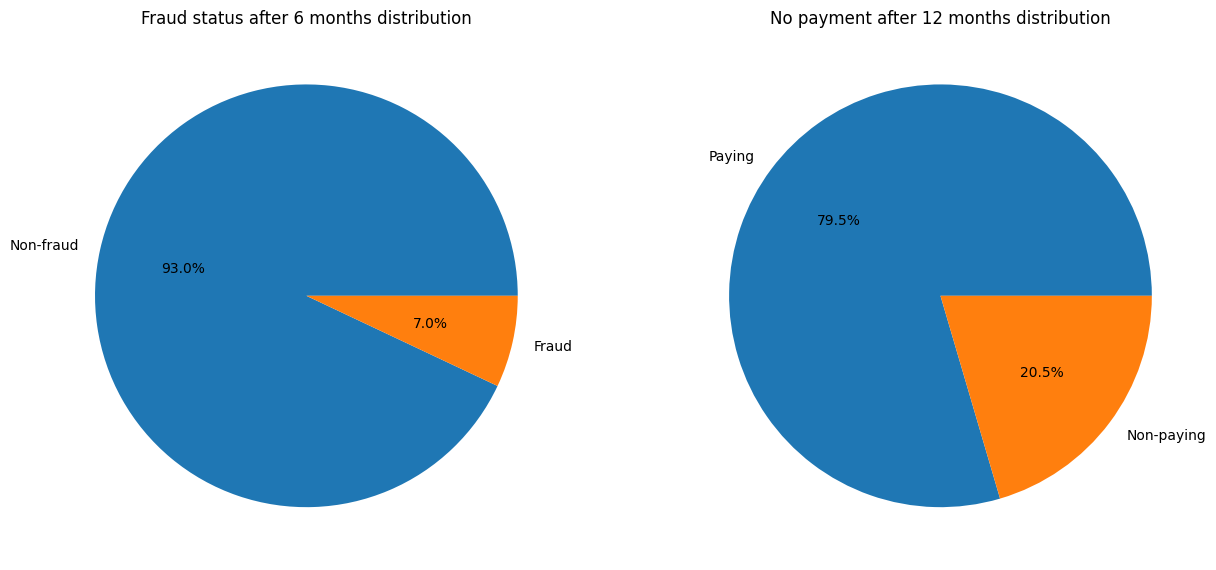

In [23]:
fig, ax = plt.subplots(1,2, figsize=(15, 15))

ax[0].pie(df['FRAUD_STATUS_6MONTH'].value_counts(), labels=['Non-fraud', 'Fraud'], autopct='%1.1f%%')
ax[0].set_title('Fraud status after 6 months distribution')

ax[1].pie(df['nopay_after_12month'].value_counts(), labels=['Paying', 'Non-paying'], autopct='%1.1f%%')
ax[1].set_title('No payment after 12 months distribution')

plt.show()

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 39714 entries, 0 to 41340
Data columns (total 21 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   DAY_ID_ENCR                    39714 non-null  object
 1   CUST_LEVEL                     39714 non-null  object
 2   GENDER_ENCR                    39714 non-null  int64 
 3   R_AGE_Y                        39714 non-null  object
 4   INSTALMENT_IND                 39714 non-null  int64 
 5   INSTAL_CNT                     39714 non-null  object
 6   PRODUCT_NAME                   39714 non-null  object
 7   MANUFACTURER_NAME_EN           39714 non-null  object
 8   OPERATING_SYSTEM               39714 non-null  object
 9   HANDSET_FEATURE_CAT_DESC       39714 non-null  object
 10  MOVING_AVERAGE_PRICE_AMT_ENCR  39714 non-null  object
 11  SELLING_PRICE_AMT_ENCR         39714 non-null  object
 12  UPFRONT_PYM_AMT_ENCR           39714 non-null  object
 13  monthl

C:\Users\gergo\AppData\Local\Temp\ipykernel_21044\2977035100.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  agePercent = (df.groupby('AGE_GROUP')['FRAUD_STATUS_6MONTH'].sum())/(df['AGE_GROUP'].value_counts())


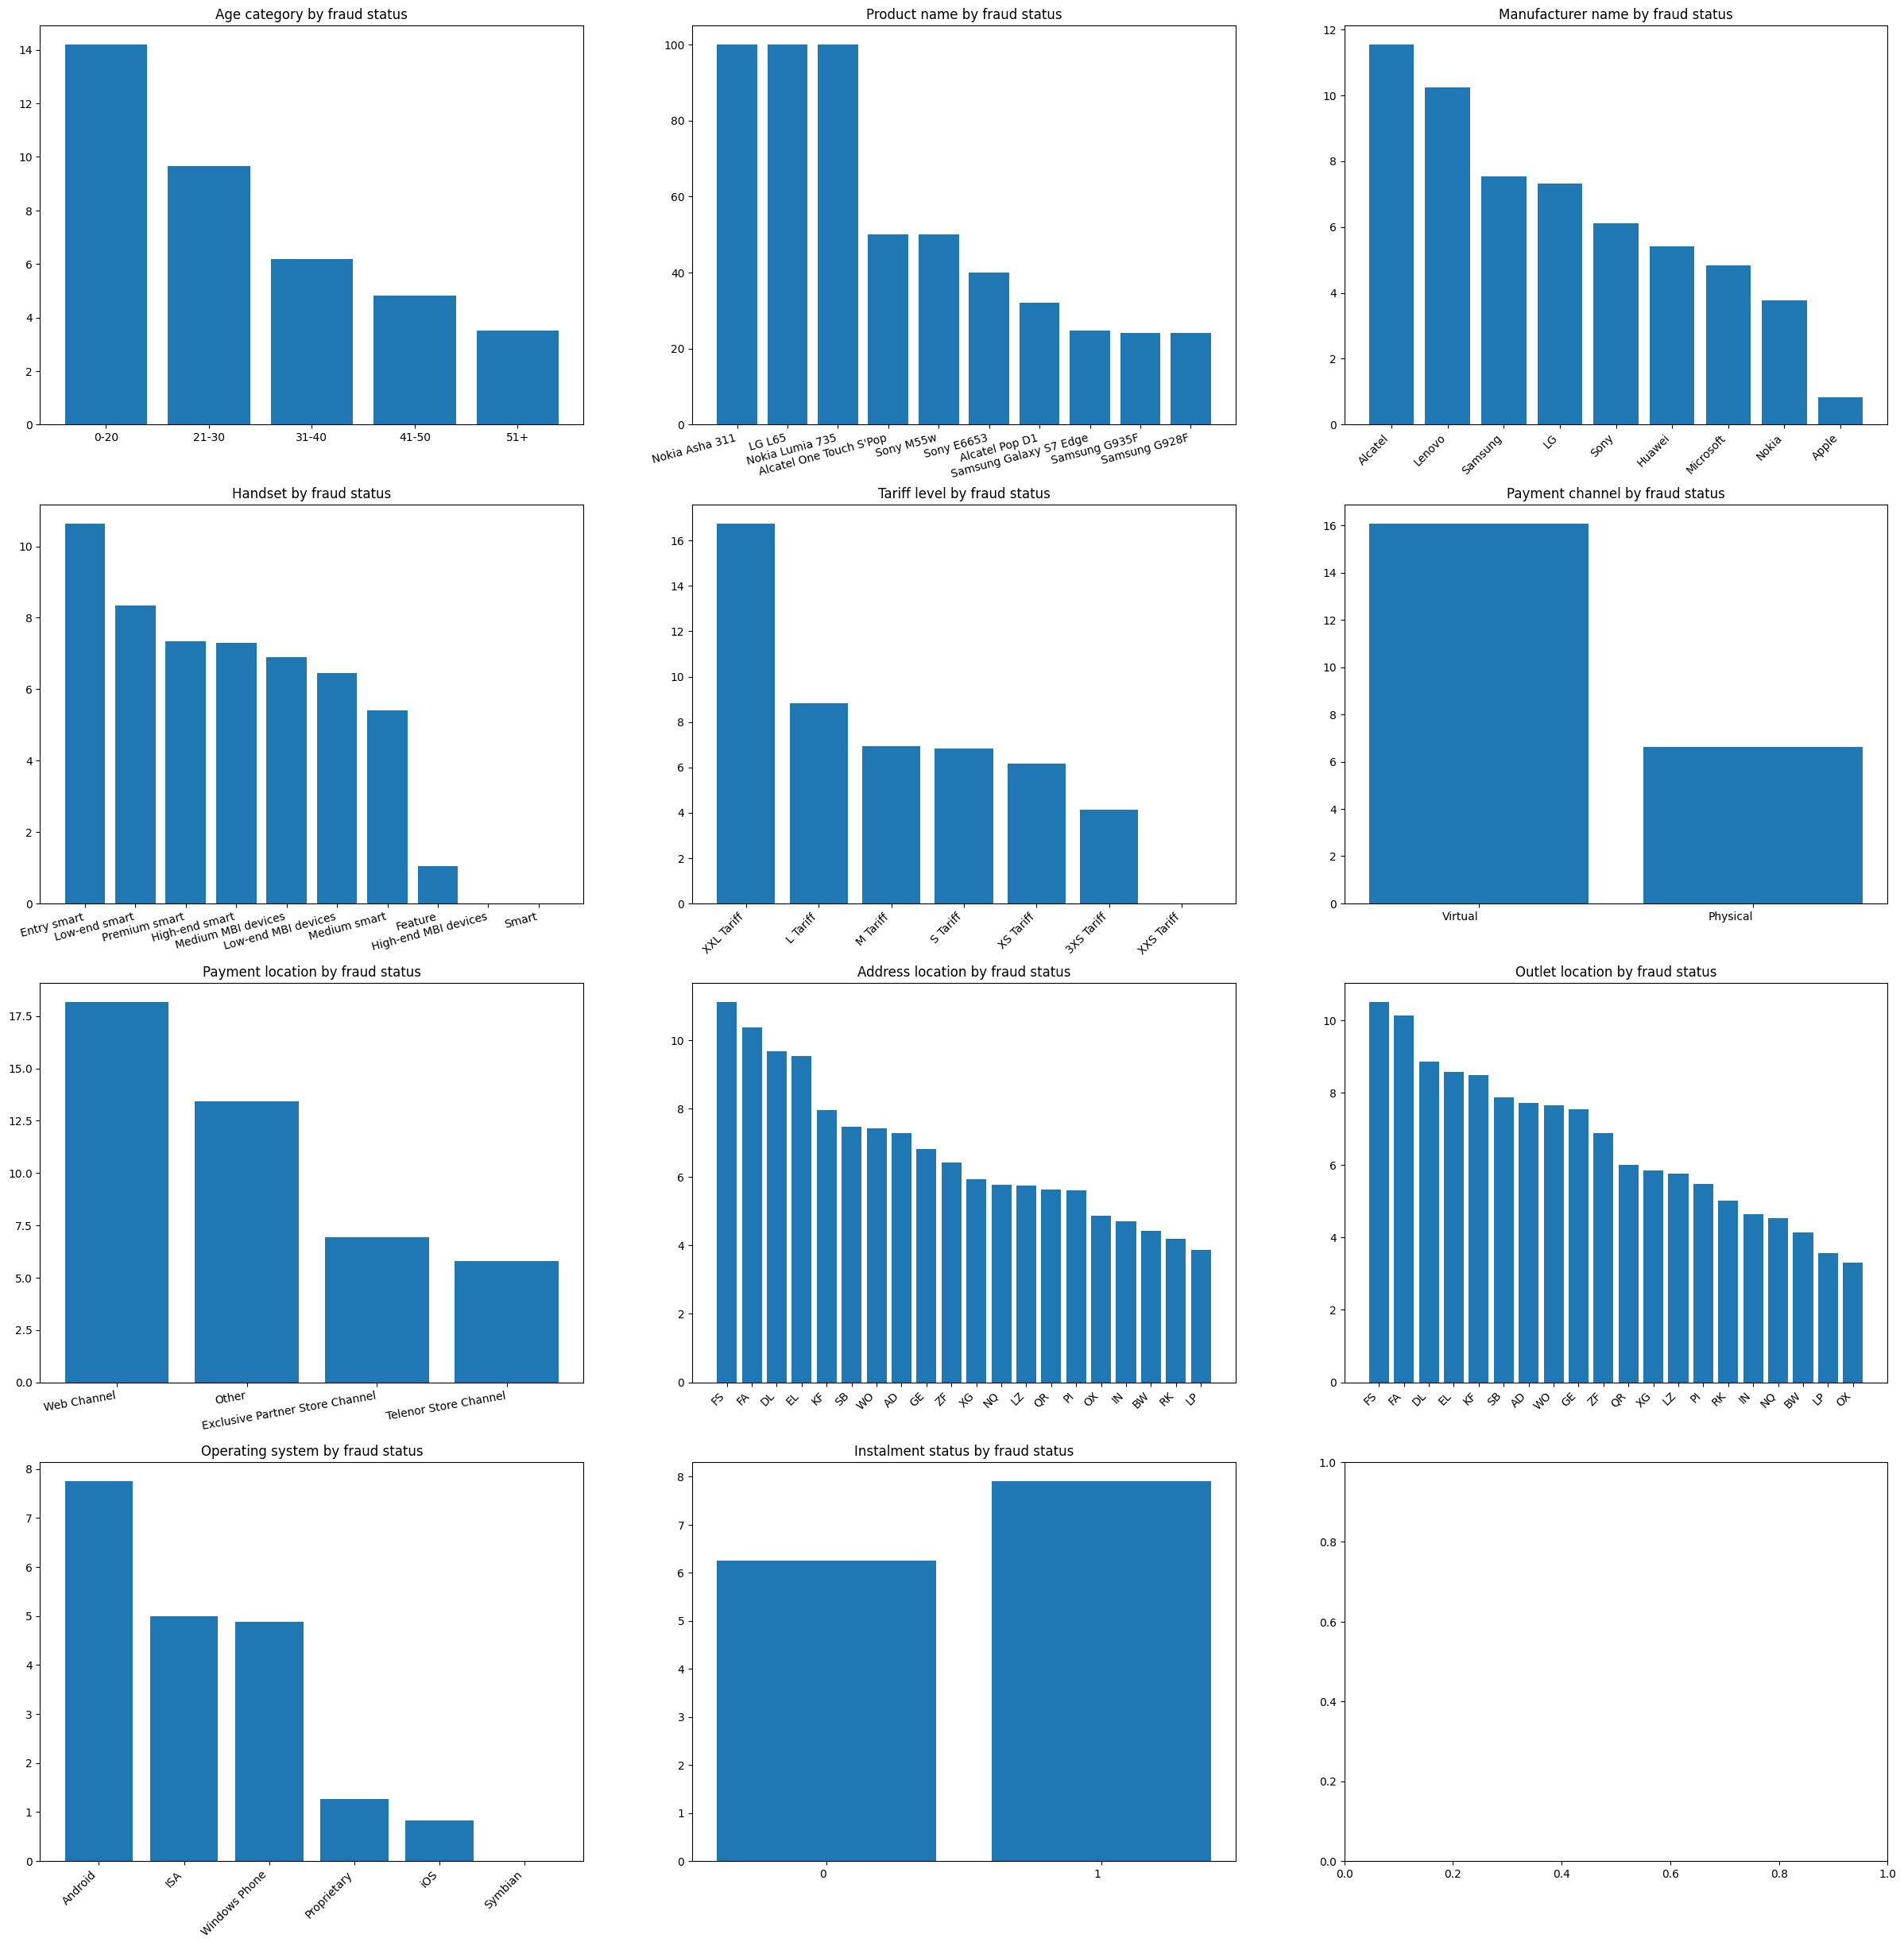

In [25]:
fig, ax = plt.subplots(4,3, figsize=(30, 30))

df['R_AGE_Y'] = pd.to_numeric(df['R_AGE_Y'], errors='coerce')
bins = [0, 20, 30, 40, 50, 100]
labels = ['0-20', '21-30', '31-40', '41-50', '51+']
df['AGE_GROUP'] = pd.cut(df['R_AGE_Y'], bins=bins, labels=labels, right=True)
agePercent = (df.groupby('AGE_GROUP')['FRAUD_STATUS_6MONTH'].sum())/(df['AGE_GROUP'].value_counts())
percent = (agePercent*100).sort_values(ascending=False)
ax[0,0].bar(percent.index, percent.values)
ax[0,0].set_xticks(percent.index)
ax[0,0].set_title('Age category by fraud status')
df=df.drop('AGE_GROUP', axis=1)

prodNamePercent = (df.groupby('PRODUCT_NAME')['FRAUD_STATUS_6MONTH'].sum())/(df['PRODUCT_NAME'].value_counts())
percent = (prodNamePercent*100).sort_values(ascending=False).head(10)
ax[0,1].bar(percent.index, percent.values)
ax[0,1].set_xticks(percent.index)
ax[0,1].set_xticklabels(percent.index, rotation=15, ha='right')
ax[0,1].set_title('Product name by fraud status')

manNamePercent = (df.groupby('MANUFACTURER_NAME_EN')['FRAUD_STATUS_6MONTH'].sum())/(df['MANUFACTURER_NAME_EN'].value_counts())
percent = (manNamePercent*100).sort_values(ascending=False)
ax[0,2].bar(percent.index, percent.values)
ax[0,2].set_xticks(percent.index)
ax[0,2].set_xticklabels(percent.index, rotation=45, ha='right')
ax[0,2].set_title('Manufacturer name by fraud status')

handsetPercent = (df.groupby('HANDSET_FEATURE_CAT_DESC')['FRAUD_STATUS_6MONTH'].sum())/(df['HANDSET_FEATURE_CAT_DESC'].value_counts())
percent = (handsetPercent*100).sort_values(ascending=False)
ax[1,0].bar(percent.index, percent.values)
ax[1,0].set_xticks(percent.index)
ax[1,0].set_xticklabels(percent.index, rotation=15, ha='right')
ax[1,0].set_title('Handset by fraud status')

tariffPercent = (df.groupby('TARIFF_LEVEL')['FRAUD_STATUS_6MONTH'].sum())/(df['TARIFF_LEVEL'].value_counts())
percent = (tariffPercent*100).sort_values(ascending=False)
ax[1,1].bar(percent.index, percent.values)
ax[1,1].set_xticks(percent.index)
ax[1,1].set_xticklabels(percent.index, rotation=45, ha='right')
ax[1,1].set_title('Tariff level by fraud status')

classPercent = (df.groupby('CHANNEL_CLASS')['FRAUD_STATUS_6MONTH'].sum())/(df['CHANNEL_CLASS'].value_counts())
percent = (classPercent*100).sort_values(ascending=False)
ax[1,2].bar(percent.index, percent.values)
ax[1,2].set_xticks(percent.index)
ax[1,2].set_xticklabels(percent.index, ha='right')
ax[1,2].set_title('Payment channel by fraud status')

groupPercent = (df.groupby('channel_group')['FRAUD_STATUS_6MONTH'].sum())/(df['channel_group'].value_counts())
percent = (groupPercent*100).sort_values(ascending=False)
ax[2,0].bar(percent.index, percent.values)
ax[2,0].set_xticks(percent.index)
ax[2,0].set_xticklabels(percent.index, rotation=10, ha='right')
ax[2,0].set_title('Payment location by fraud status')

addressPercent = (df.groupby('ADDRESS_COUNTY_ENCR')['FRAUD_STATUS_6MONTH'].sum())/(df['ADDRESS_COUNTY_ENCR'].value_counts())
percent = (addressPercent*100).sort_values(ascending=False)
ax[2,1].bar(percent.index, percent.values)
ax[2,1].set_xticks(percent.index)
ax[2,1].set_xticklabels(percent.index, rotation=45, ha='right')
ax[2,1].set_title('Address location by fraud status')

outletPercent = (df.groupby('OUTLET_COUNTY_ENCR')['FRAUD_STATUS_6MONTH'].sum())/(df['OUTLET_COUNTY_ENCR'].value_counts())
percent = (outletPercent*100).sort_values(ascending=False)
ax[2,2].bar(percent.index, percent.values)
ax[2,2].set_xticks(percent.index)
ax[2,2].set_xticklabels(percent.index, rotation=45, ha='right')
ax[2,2].set_title('Outlet location by fraud status')

opSysPercent = (df.groupby('OPERATING_SYSTEM')['FRAUD_STATUS_6MONTH'].sum())/(df['OPERATING_SYSTEM'].value_counts())
percent = (opSysPercent*100).sort_values(ascending=False)
ax[3,0].bar(percent.index, percent.values)
ax[3,0].set_xticks(percent.index)
ax[3,0].set_xticklabels(percent.index, rotation=45, ha='right')
ax[3,0].set_title('Operating system by fraud status')

instPercent = (df.groupby('INSTALMENT_IND')['FRAUD_STATUS_6MONTH'].sum())/(df['INSTALMENT_IND'].value_counts())
percent = (instPercent*100).sort_values(ascending=False)
ax[3,1].bar(percent.index, percent.values)
ax[3,1].set_xticks(percent.index)
ax[3,1].set_xticklabels(percent.index,  ha='right')
ax[3,1].set_title('Instalment status by fraud status')

plt.show()

C:\Users\gergo\AppData\Local\Temp\ipykernel_21044\3404328151.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  agePercent = (df.groupby('AGE_GROUP')['nopay_after_12month'].sum())/(df['AGE_GROUP'].value_counts())


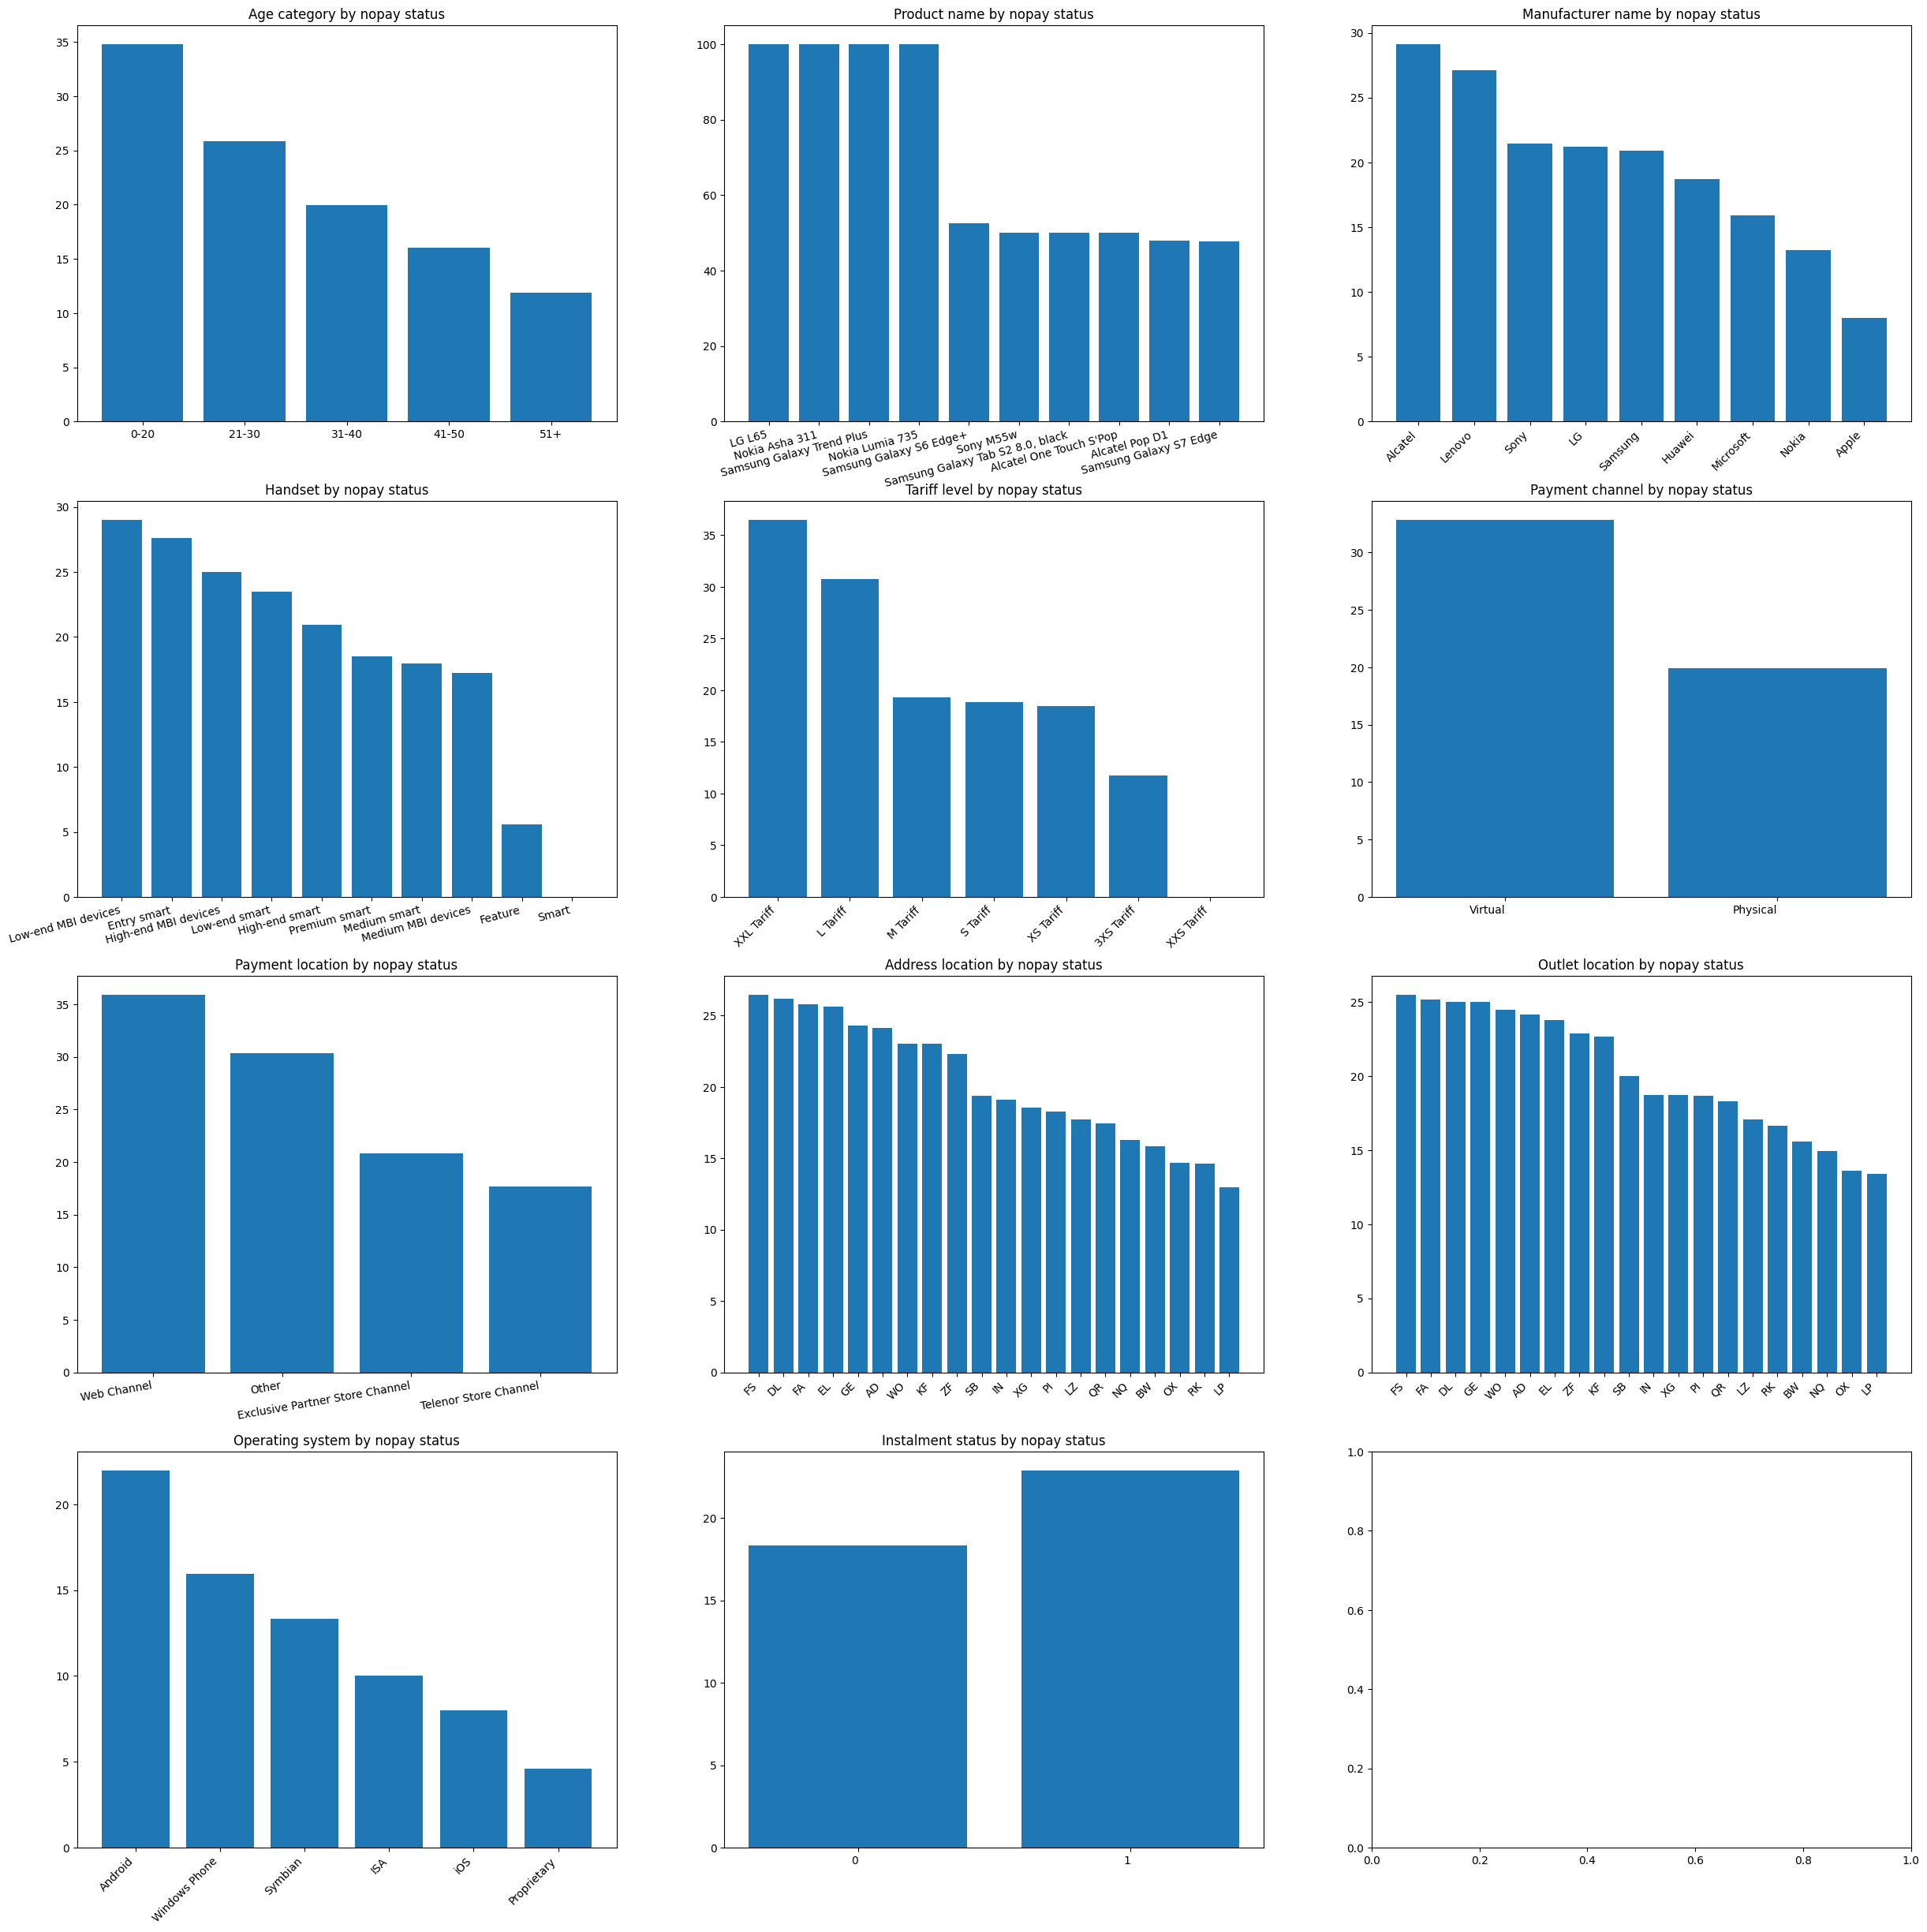

In [26]:
fig, ax = plt.subplots(4,3, figsize=(30, 30))

df['R_AGE_Y'] = pd.to_numeric(df['R_AGE_Y'], errors='coerce')
bins = [0, 20, 30, 40, 50, 100]
labels = ['0-20', '21-30', '31-40', '41-50', '51+']
df['AGE_GROUP'] = pd.cut(df['R_AGE_Y'], bins=bins, labels=labels, right=True)
agePercent = (df.groupby('AGE_GROUP')['nopay_after_12month'].sum())/(df['AGE_GROUP'].value_counts())
percent = (agePercent*100).sort_values(ascending=False)
ax[0,0].bar(percent.index, percent.values)
ax[0,0].set_xticks(percent.index)
ax[0,0].set_title('Age category by nopay status')
df=df.drop('AGE_GROUP', axis=1)

prodNamePercent = (df.groupby('PRODUCT_NAME')['nopay_after_12month'].sum())/(df['PRODUCT_NAME'].value_counts())
percent = (prodNamePercent*100).sort_values(ascending=False).head(10)
ax[0,1].bar(percent.index, percent.values)
ax[0,1].set_xticks(percent.index)
ax[0,1].set_xticklabels(percent.index, rotation=15, ha='right')
ax[0,1].set_title('Product name by nopay status')

manNamePercent = (df.groupby('MANUFACTURER_NAME_EN')['nopay_after_12month'].sum())/(df['MANUFACTURER_NAME_EN'].value_counts())
percent = (manNamePercent*100).sort_values(ascending=False)
ax[0,2].bar(percent.index, percent.values)
ax[0,2].set_xticks(percent.index)
ax[0,2].set_xticklabels(percent.index, rotation=45, ha='right')
ax[0,2].set_title('Manufacturer name by nopay status')

handsetPercent = (df.groupby('HANDSET_FEATURE_CAT_DESC')['nopay_after_12month'].sum())/(df['HANDSET_FEATURE_CAT_DESC'].value_counts())
percent = (handsetPercent*100).sort_values(ascending=False)
ax[1,0].bar(percent.index, percent.values)
ax[1,0].set_xticks(percent.index)
ax[1,0].set_xticklabels(percent.index, rotation=15, ha='right')
ax[1,0].set_title('Handset by nopay status')

tariffPercent = (df.groupby('TARIFF_LEVEL')['nopay_after_12month'].sum())/(df['TARIFF_LEVEL'].value_counts())
percent = (tariffPercent*100).sort_values(ascending=False)
ax[1,1].bar(percent.index, percent.values)
ax[1,1].set_xticks(percent.index)
ax[1,1].set_xticklabels(percent.index, rotation=45, ha='right')
ax[1,1].set_title('Tariff level by nopay status')

classPercent = (df.groupby('CHANNEL_CLASS')['nopay_after_12month'].sum())/(df['CHANNEL_CLASS'].value_counts())
percent = (classPercent*100).sort_values(ascending=False)
ax[1,2].bar(percent.index, percent.values)
ax[1,2].set_xticks(percent.index)
ax[1,2].set_xticklabels(percent.index, ha='right')
ax[1,2].set_title('Payment channel by nopay status')

groupPercent = (df.groupby('channel_group')['nopay_after_12month'].sum())/(df['channel_group'].value_counts())
percent = (groupPercent*100).sort_values(ascending=False)
ax[2,0].bar(percent.index, percent.values)
ax[2,0].set_xticks(percent.index)
ax[2,0].set_xticklabels(percent.index, rotation=10, ha='right')
ax[2,0].set_title('Payment location by nopay status')

addressPercent = (df.groupby('ADDRESS_COUNTY_ENCR')['nopay_after_12month'].sum())/(df['ADDRESS_COUNTY_ENCR'].value_counts())
percent = (addressPercent*100).sort_values(ascending=False)
ax[2,1].bar(percent.index, percent.values)
ax[2,1].set_xticks(percent.index)
ax[2,1].set_xticklabels(percent.index, rotation=45, ha='right')
ax[2,1].set_title('Address location by nopay status')

outletPercent = (df.groupby('OUTLET_COUNTY_ENCR')['nopay_after_12month'].sum())/(df['OUTLET_COUNTY_ENCR'].value_counts())
percent = (outletPercent*100).sort_values(ascending=False)
ax[2,2].bar(percent.index, percent.values)
ax[2,2].set_xticks(percent.index)
ax[2,2].set_xticklabels(percent.index, rotation=45, ha='right')
ax[2,2].set_title('Outlet location by nopay status')

opSysPercent = (df.groupby('OPERATING_SYSTEM')['nopay_after_12month'].sum())/(df['OPERATING_SYSTEM'].value_counts())
percent = (opSysPercent*100).sort_values(ascending=False)
ax[3,0].bar(percent.index, percent.values)
ax[3,0].set_xticks(percent.index)
ax[3,0].set_xticklabels(percent.index, rotation=45, ha='right')
ax[3,0].set_title('Operating system by nopay status')

instPercent = (df.groupby('INSTALMENT_IND')['nopay_after_12month'].sum())/(df['INSTALMENT_IND'].value_counts())
percent = (instPercent*100).sort_values(ascending=False)
ax[3,1].bar(percent.index, percent.values)
ax[3,1].set_xticks(percent.index)
ax[3,1].set_xticklabels(percent.index,  ha='right')
ax[3,1].set_title('Instalment status by nopay status')

plt.show()

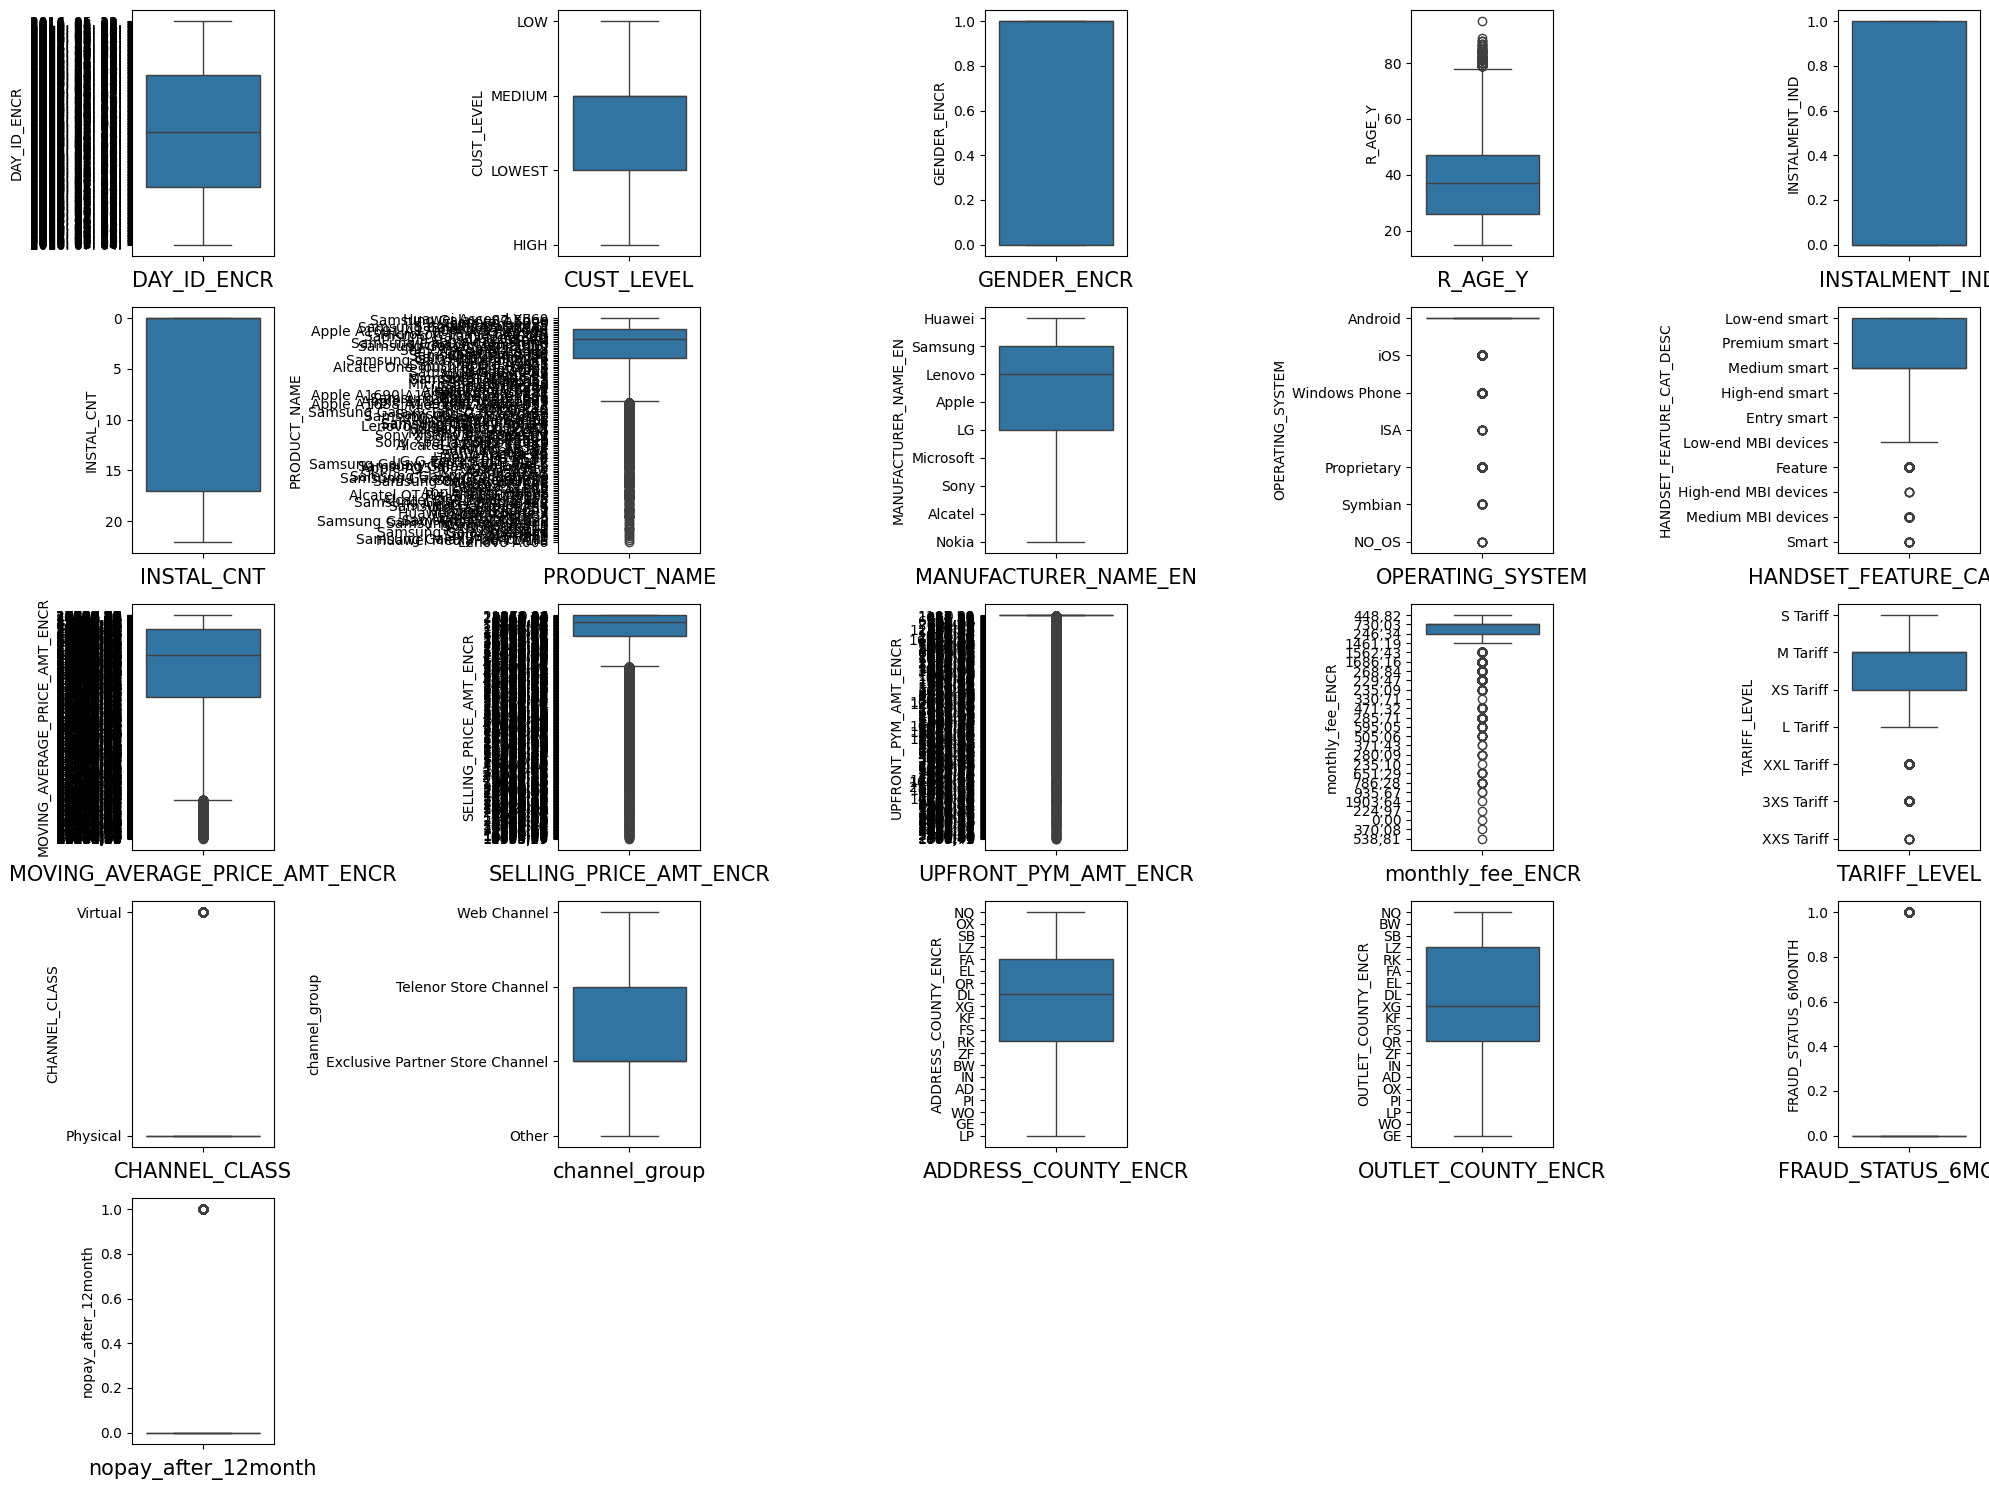

In [122]:
#ooutlier detector

plt.figure(figsize = (20, 15))
plotnumber = 1

for col in df.columns:
    if plotnumber <= 21:
        ax = plt.subplot(5, 5, plotnumber)
        sns.boxplot(df[col])
        plt.xlabel(col, fontsize = 15)
    
    plotnumber += 1
plt.tight_layout()
plt.show()

In [123]:
df.head()

DAY_ID_ENCR CUST_LEVEL  GENDER_ENCR  R_AGE_Y  INSTALMENT_IND INSTAL_CNT  \
0  2016. 05. 22.        LOW            1       19               0          0   
1  2016. 05. 12.     MEDIUM            1       24               1         17   
2  2015. 11. 20.     MEDIUM            0       29               0          0   
3  2016. 05. 07.     LOWEST            0       58               1         22   
4  2016. 04. 07.     LOWEST            0       31               1          6   

             PRODUCT_NAME MANUFACTURER_NAME_EN OPERATING_SYSTEM  \
0      Huawei Ascend Y560               Huawei          Android   
1  Samsung Galaxy S7 Edge              Samsung          Android   
2            Lenovo A6000               Lenovo          Android   
3          Apple iPhone5S                Apple              iOS   
4       Samsung Galaxy J5              Samsung          Android   

  HANDSET_FEATURE_CAT_DESC  ... SELLING_PRICE_AMT_ENCR UPFRONT_PYM_AMT_ENCR  \
0            Low-end smart  ...                   0,00                 0,00   
1            Premium smart  ...               21371,14              1187,29   
2             Medium smart  ...                   0,00                 0,00   
3            Premium smart  ...               11247,43                 0,00   
4             Medium smart  ...                5060,71               421,71   

  monthly_fee_ENCR TARIFF_LEVEL CHANNEL_CLASS  \
0           448,82     S Tariff       Virtual   
1           730,03     M Tariff      Physical   
2           730,03     M Tariff      Physical   
3           246,34    XS Tariff      Physical   
4           246,34    XS Tariff      Physical   

                     channel_group ADDRESS_COUNTY_ENCR OUTLET_COUNTY_ENCR  \
0                      Web Channel                  NQ                 NQ   
1            Telenor Store Channel                  OX                 BW   
2            Telenor Store Channel                  SB                 SB   
3  Exclusive Partner Store Channel                  LZ                 LZ   
4  Exclusive Partner Store Channel                  FA                 RK   

  FRAUD_STATUS_6MONTH  nopay_after_12month  
0                   0                    0  
1                   1                    1  
2                   0                    0  
3                   0                    0  
4                   0                    0  

[5 rows x 21 columns]

In [124]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 39714 entries, 0 to 41340
Data columns (total 21 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   DAY_ID_ENCR                    39714 non-null  object
 1   CUST_LEVEL                     39714 non-null  object
 2   GENDER_ENCR                    39714 non-null  int64 
 3   R_AGE_Y                        39714 non-null  int64 
 4   INSTALMENT_IND                 39714 non-null  int64 
 5   INSTAL_CNT                     39714 non-null  object
 6   PRODUCT_NAME                   39714 non-null  object
 7   MANUFACTURER_NAME_EN           39714 non-null  object
 8   OPERATING_SYSTEM               39714 non-null  object
 9   HANDSET_FEATURE_CAT_DESC       39714 non-null  object
 10  MOVING_AVERAGE_PRICE_AMT_ENCR  39714 non-null  object
 11  SELLING_PRICE_AMT_ENCR         39714 non-null  object
 12  UPFRONT_PYM_AMT_ENCR           39714 non-null  object
 13  monthl

In [125]:
#drop the prod_name because the very big product name variance
df = df.drop('PRODUCT_NAME', axis=1)

In [126]:
df['DAY_ID_ENCR'] = pd.to_datetime(df['DAY_ID_ENCR'], format='%Y. %m. %d.')

df['INSTAL_CNT'] = pd.to_numeric(df['INSTAL_CNT'], errors='coerce')

In [127]:
#convert to numeric and scale price-related features

columns_to_fix = [
    'MOVING_AVERAGE_PRICE_AMT_ENCR',
    'SELLING_PRICE_AMT_ENCR',
    'UPFRONT_PYM_AMT_ENCR',
    'monthly_fee_ENCR'
]
from sklearn.preprocessing import StandardScaler

for col in columns_to_fix:
    df[col] = df[col].str.replace(',', '.').astype(float)

scaler = StandardScaler()
df_scaled = df.copy()
df_scaled[columns_to_fix] = scaler.fit_transform(df[columns_to_fix])


In [128]:
from sklearn.preprocessing import LabelEncoder
cat_features = {'CUST_LEVEL','MANUFACTURER_NAME_EN', 'OPERATING_SYSTEM', 'HANDSET_FEATURE_CAT_DESC', 'TARIFF_LEVEL', 'CHANNEL_CLASS', 'channel_group', 'ADDRESS_COUNTY_ENCR', 'OUTLET_COUNTY_ENCR'}

for col in cat_features:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))

Text(0.5, 1.0, 'Correlation heatmap')

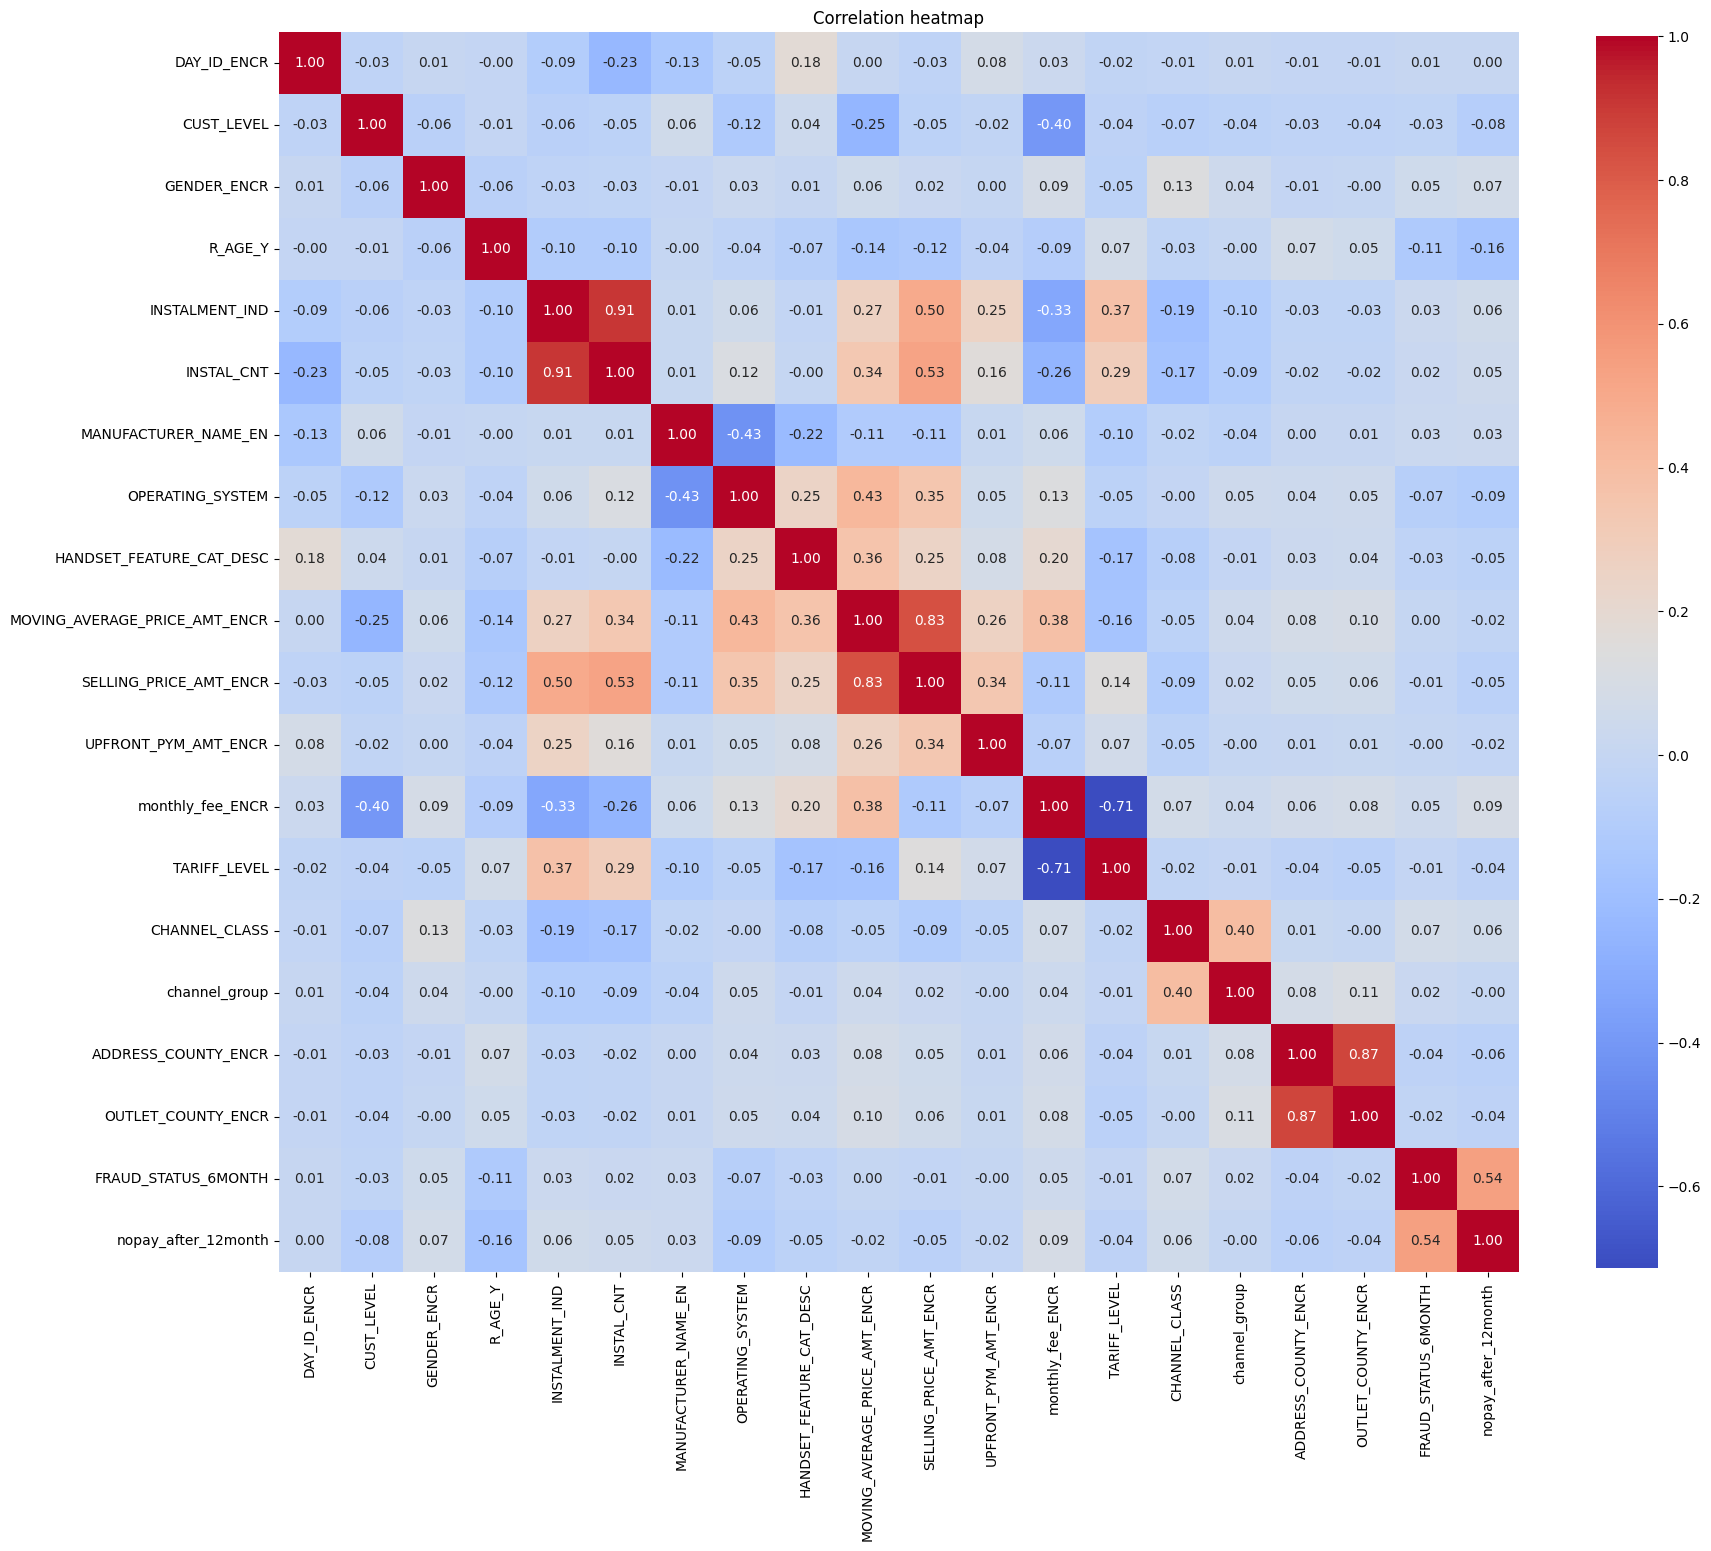

In [129]:
corr = df.corr()
plt.figure(figsize=(20, 20))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', square=True, cbar_kws={'shrink': .8})
plt.title('Correlation heatmap')

In [ ]:
df_check = df[
    (df['INSTAL_CNT'] <= 12) & 
    (df['nopay_after_12month'] == '1')
]

print(df_check.shape[0])
#it seems there are no clients who dont pay cause the installment period is over, so all of the nopay_after_12month positive clinets have some debts

0


In [131]:
fraud_count = df[df['FRAUD_STATUS_6MONTH'] == 1].shape[0]

fraud_and_nopay_count = df[
    (df['FRAUD_STATUS_6MONTH'] == 1) &
    (df['nopay_after_12month'] == 1)
].shape[0]

fraud_covered_by_nopay_ratio = fraud_and_nopay_count / fraud_count if fraud_count > 0 else 0

print('Fraud cloents:', fraud_count)
print('Fraud + NoPay clients:', fraud_and_nopay_count)
print('Ratio:', fraud_covered_by_nopay_ratio)

Fraud cloents: 2786
Fraud + NoPay clients: 2786
Ratio: 1.0


In [132]:
print(df[df['nopay_after_12month'] == 1].shape[0])

8122


the fraud feature is a subset of nopay, and it is safe to say that the nopay client did not pay because the instalinstallment period expired, so I will only use nopay in the future

In [133]:
df_2 = df.copy()

In [32]:
df['device_discount'] = df['MOVING_AVERAGE_PRICE_AMT_ENCR'] - df['SELLING_PRICE_AMT_ENCR']

df['real_monthly_cost'] = df['monthly_fee_ENCR'] + ((df['SELLING_PRICE_AMT_ENCR'] - df['UPFRONT_PYM_AMT_ENCR']) / df['INSTAL_CNT'])

cols_to_drop = [
    'MOVING_AVERAGE_PRICE_AMT_ENCR',
    'DAY_ID_ENCR',
    'INSTAL_CNT',
    'TARIFF_LEVEL',
    'channel_group',
    'FRAUD_STATUS_6MONTH'
]

df.drop(columns=cols_to_drop, inplace=True, errors='ignore')

In [33]:
df.loc[(df['INSTALMENT_IND'] == 0) & (df['real_monthly_cost'].isna()),'real_monthly_cost'] = df['monthly_fee_ENCR']

In [34]:
inf_per_column_train = df.apply(lambda col: np.isinf(col).sum())
print(inf_per_column_train[inf_per_column_train > 0])

real_monthly_cost    11131
dtype: int64


In [35]:
df[np.isinf(df).any(axis=1)]

CUST_LEVEL  GENDER_ENCR  R_AGE_Y  INSTALMENT_IND  MANUFACTURER_NAME_EN  \
6               2            0       35               0                     4   
8               2            0       41               0                     3   
15              3            1       59               0                     3   
18              3            1       35               0                     3   
28              2            1       25               0                     7   
...           ...          ...      ...             ...                   ...   
41326           2            1       54               0                     2   
41327           2            1       20               0                     2   
41328           1            1       42               0                     7   
41337           2            0       61               0                     3   
41340           2            1       66               0                     5   

       OPERATING_SYSTEM  HANDSET_FEATURE_CAT_DESC  SELLING_PRICE_AMT_ENCR  \
6                     0                         5                 1461.14   
8                     0                         5                 3036.00   
15                    0                         5                  561.29   
18                    0                         7                  337.29   
28                    0                         3                 8772.71   
...                 ...                       ...                     ...   
41326                 0                         5                 1461.14   
41327                 0                         5                 1461.14   
41328                 0                         3                10938.29   
41337                 0                         5                 2923.43   
41340                 5                         7                 6410.57   

       UPFRONT_PYM_AMT_ENCR  monthly_fee_ENCR  CHANNEL_CLASS  \
6                       0.0            246.34              0   
8                       0.0            246.34              0   
15                      0.0            730.03              0   
18                      0.0            730.03              0   
28                      0.0            246.34              0   
...                     ...               ...            ...   
41326                   0.0            246.34              0   
41327                   0.0            246.34              0   
41328                   0.0            448.82              0   
41337                   0.0            246.34              0   
41340                   0.0            246.34              0   

       ADDRESS_COUNTY_ENCR  OUTLET_COUNTY_ENCR  nopay_after_12month  \
6                        3                   3                    0   
8                       16                  16                    0   
15                      16                  16                    0   
18                      15                  15                    0   
28                       1                   1                    0   
...                    ...                 ...                  ...   
41326                   14                  14                    0   
41327                    4                   4                    1   
41328                   16                  16                    0   
41337                   14                  14                    0   
41340                   14                  14                    0   

       device_discount  real_monthly_cost  
6              1374.86                inf  
8              1747.00                inf  
15             3025.57                inf  
18             4193.00                inf  
28              -45.57                inf  
...                ...                ...  
41326          1420.00                inf  
41327          1420.00                inf  
41328           852.28                inf  
41337          1849.57                inf  
413

In [ ]:
#there are inf in the real_monthly_cos feature where the selling price isnt 0, we can solve this with set it to the monthly fee
infs = np.isinf(df)
for col in df.columns[infs.any(axis=0)]:
    df.loc[infs[col], col] = df.loc[infs[col], 'monthly_fee_ENCR']


Building models

In [37]:
X = df.drop(columns=['nopay_after_12month'])
y = df['nopay_after_12month']

In [38]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2, stratify=y, random_state=42)

In [42]:
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score,ConfusionMatrixDisplay, f1_score, precision_score, recall_score)

def evaluate_metrics(model, X_test, y_test, model_name='Model'):
    y_proba = model.predict_proba(X_test)[:, 1]
    thresholds = np.linspace(0.1, 0.9, 81)
    f1s = [f1_score(y_test, (y_proba > t).astype(int)) for t in thresholds]
    best_threshold = thresholds[np.argmax(f1s)]

    y_pred = (y_proba > best_threshold).astype(int)

    print(f'Evaluation results for: {model_name}')
    print('Classification Report:\n', classification_report(y_test, y_pred))
    print('ROC AUC Score:', roc_auc_score(y_test, y_proba))
    print('F1 Score:', f1_score(y_test, y_pred))
    print('Precision:', precision_score(y_test, y_pred))
    print('Recall:', recall_score(y_test, y_pred))
    print('Best threshold (F1 optimalized):', best_threshold)

    

    classes = {'Not nopay' : 0,'Nopay' : 1}
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 5))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes.keys())
    disp.plot(values_format='d', cmap='viridis')
    plt.title(f'{model_name} - Confusion Matrix (optimal threshold)')
    plt.show()

    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        features_sorted = pd.Series(importances, index=X_test.columns).sort_values(ascending=True)

        plt.figure(figsize=(10, 6))
        features_sorted.plot(kind='barh')
        plt.title(f'{model_name} - Feature Importances')
        plt.xlabel('Importance')
        plt.tight_layout()
        plt.show()

RandomForestClassifier

Evaluation results for: random_forest
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.72      0.79      6319
           1       0.35      0.58      0.43      1624

    accuracy                           0.69      7943
   macro avg       0.61      0.65      0.61      7943
weighted avg       0.76      0.69      0.72      7943

ROC AUC Score: 0.7104667427267987
F1 Score: 0.43377941855099217
Precision: 0.34686346863468637
Recall: 0.5788177339901478
Best threshold (F1 optimalized): 0.24000000000000002


<Figure size 800x500 with 0 Axes>

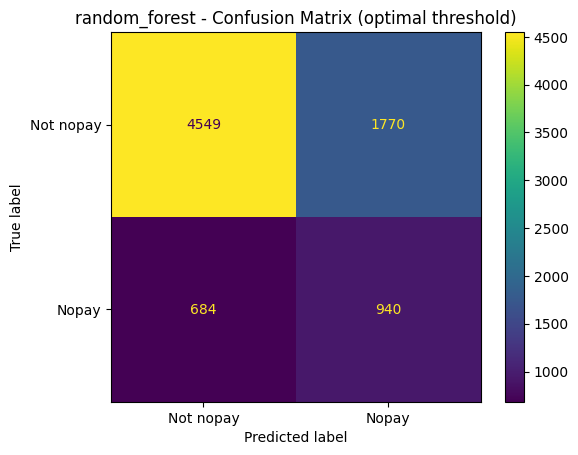

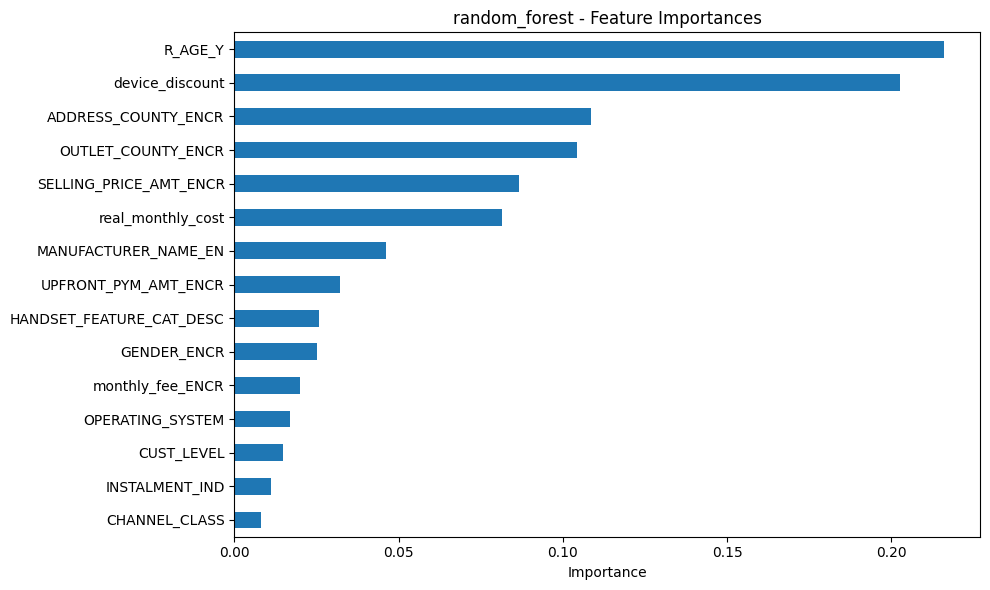

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=42, class_weight='balanced')
rf.fit(X_train, y_train)

evaluate_metrics(rf, X_test, y_test, 'random_forest')

XGBClassifier

Evaluation results for: XGBoost
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.74      0.80      6319
           1       0.37      0.60      0.46      1624

    accuracy                           0.71      7943
   macro avg       0.62      0.67      0.63      7943
weighted avg       0.77      0.71      0.73      7943

ROC AUC Score: 0.7344978433171676
F1 Score: 0.4581560283687943
Precision: 0.3718342287029931
Recall: 0.5966748768472906
Best threshold (F1 optimalized): 0.58


<Figure size 800x500 with 0 Axes>

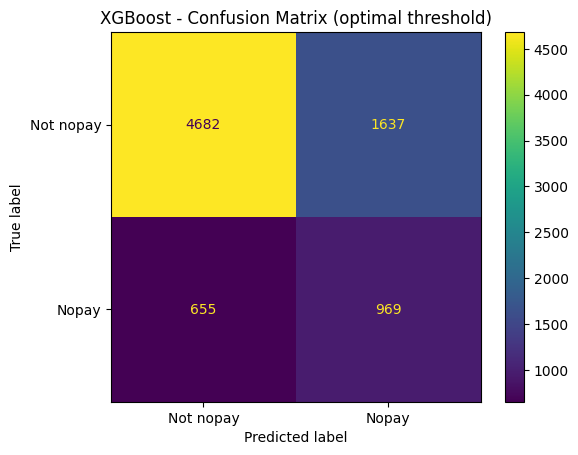

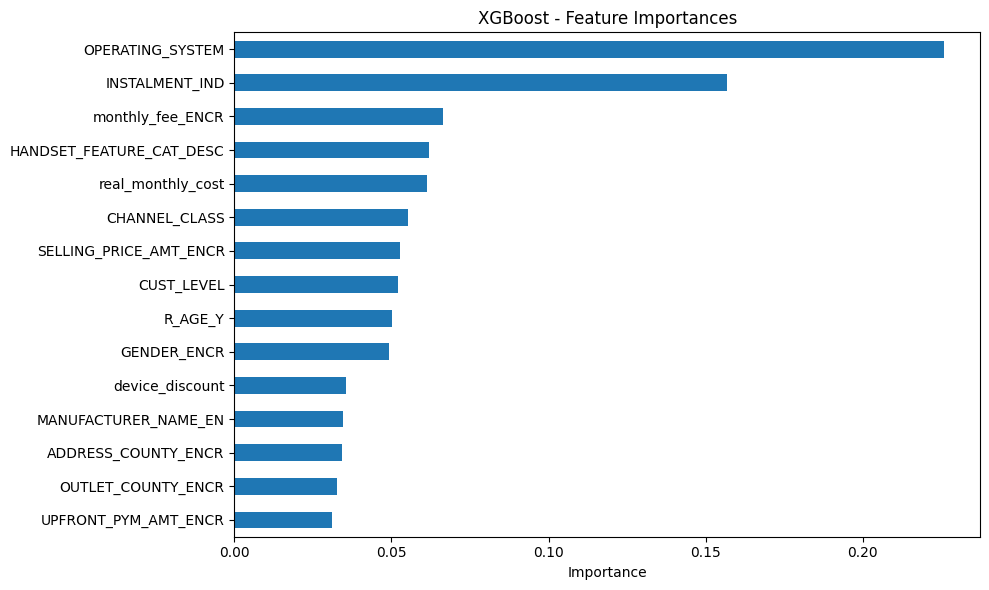

In [45]:
from xgboost import XGBClassifier

xgb = XGBClassifier(random_state=42, scale_pos_weight=(len(y_train) / sum(y_train)))
xgb.fit(X_train, y_train)

evaluate_metrics(xgb, X_test, y_test, 'XGBoost')


Fitting 5 folds for each of 72 candidates, totalling 360 fits


C:\Users\gergo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:158: UserWarning: [17:13:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Evaluation results for: XGBoost with GridSearch
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.73      0.79      6319
           1       0.36      0.60      0.45      1624

    accuracy                           0.70      7943
   macro avg       0.62      0.66      0.62      7943
weighted avg       0.77      0.70      0.72      7943

ROC AUC Score: 0.7286843883915659
F1 Score: 0.4486586493987049
Precision: 0.3592592592592593
Recall: 0.5972906403940886
Best threshold (F1 optimalized): 0.22


<Figure size 800x500 with 0 Axes>

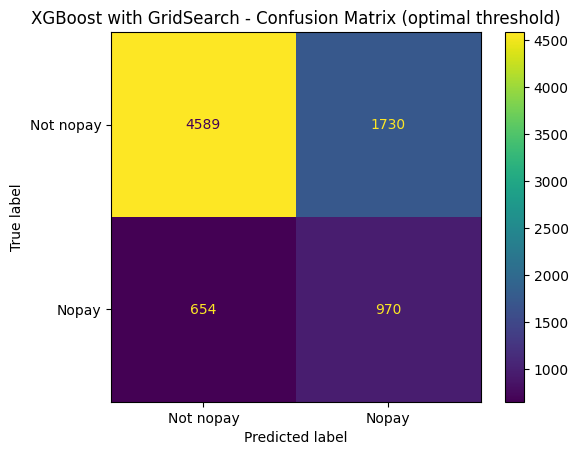

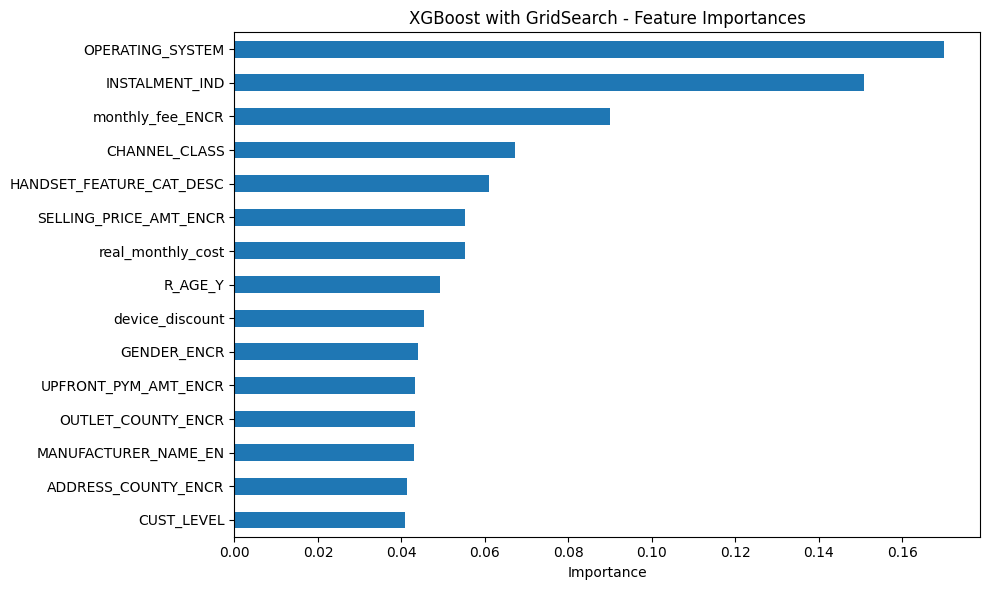

In [47]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

xgb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring='f1',
    cv=5,
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

best_xgb = grid_search.best_estimator_

evaluate_metrics(best_xgb, X_test, y_test, 'XGBoost with GridSearch')

Training 2.0

In [ ]:
df_segmented = df[df['INSTALMENT_IND'] == 1].copy()
df_segmented = df_segmented.drop('INSTALMENT_IND', axis=1)

In [50]:
X = df_segmented.drop(columns=['nopay_after_12month'])
y = df_segmented['nopay_after_12month']

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)

C:\Users\gergo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:158: UserWarning: [17:22:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Evaluation results for: XGBoost Instalment
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.60      0.70      4241
           1       0.33      0.66      0.44      1259

    accuracy                           0.61      5500
   macro avg       0.59      0.63      0.57      5500
weighted avg       0.73      0.61      0.64      5500

ROC AUC Score: 0.6735420089713879
F1 Score: 0.43508032657361073
Precision: 0.32545311268715527
Recall: 0.6560762509928515
Best threshold (F1 optimalized): 0.43000000000000005


<Figure size 800x500 with 0 Axes>

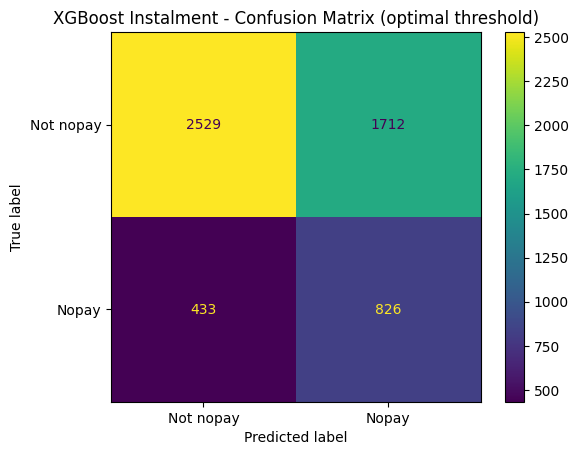

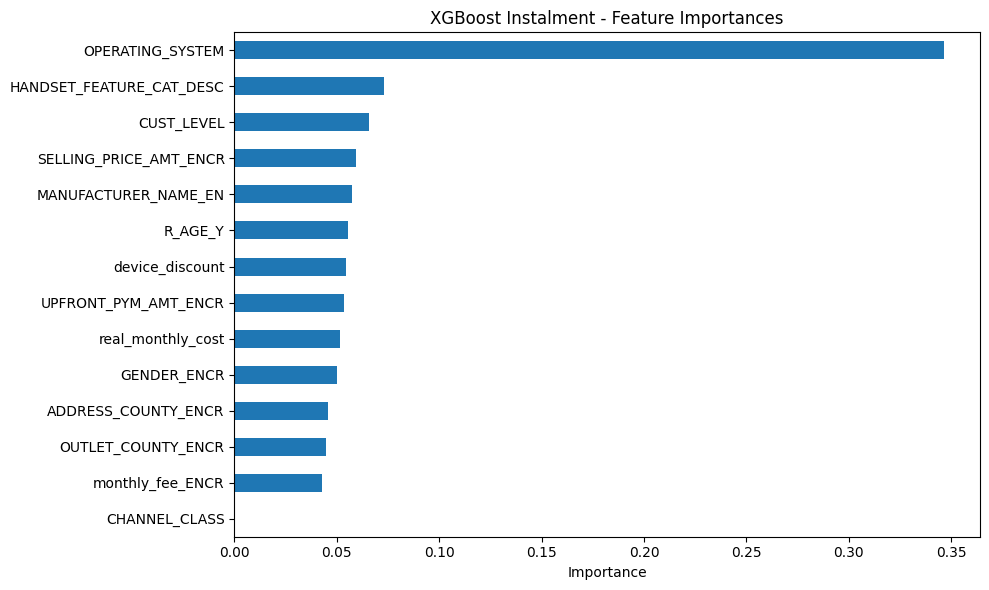

In [59]:
xgb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='auc', scale_pos_weight = len(y_train) / sum(y_train))
xgb.fit(X_train, y_train)
evaluate_metrics(xgb, X_test, y_test, model_name='XGBoost Instalment')

In [ ]:
df_non_inst = df[df['INSTALMENT_IND'] == 0].copy()
df_non_inst = df_non_inst.drop('INSTALMENT_IND', axis=1)

In [55]:
X_non = df_non_inst.drop(columns=['nopay_after_12month'])
y_non = df_non_inst['nopay_after_12month']

In [ ]:
X_train_non, X_test_non, y_train_non, y_test_non = train_test_split(X_non, y_non, stratify=y_non, test_size=0.3, random_state=42)

C:\Users\gergo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:158: UserWarning: [17:24:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Evaluation results for: XGBoost NoInstalment
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.77      0.83      5237
           1       0.35      0.55      0.43      1178

    accuracy                           0.73      6415
   macro avg       0.62      0.66      0.63      6415
weighted avg       0.79      0.73      0.75      6415

ROC AUC Score: 0.731371367308426
F1 Score: 0.42919026991003
Precision: 0.3532638507953922
Recall: 0.5466893039049237
Best threshold (F1 optimalized): 0.58


<Figure size 800x500 with 0 Axes>

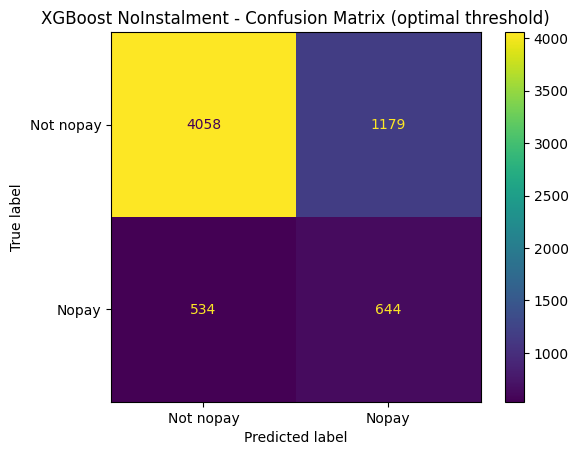

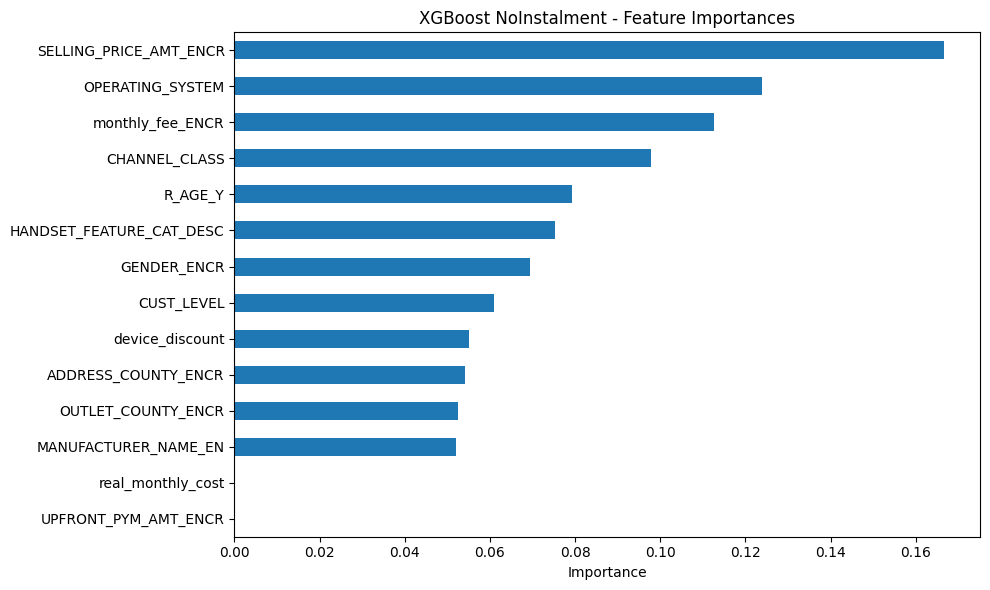

In [62]:
xgb_non = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='auc', scale_pos_weight = len(y_train_non) / sum(y_train_non))
xgb_non.fit(X_train_non, y_train_non)
evaluate_metrics(xgb_non, X_test_non, y_test_non, model_name='XGBoost NoInstalment')

Optimization with regularization

Fitting 3 folds for each of 1296 candidates, totalling 3888 fits


C:\Users\gergo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
C:\Users\gergo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:158: UserWarning: [18:07:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Evaluation results for: XGBoost Instalment (Optimization with regularization)
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.67      0.75      4241
           1       0.36      0.62      0.46      1259

    accuracy                           0.66      5500
   macro avg       0.61      0.65      0.61      5500
weighted avg       0.74      0.66      0.69      5500

ROC AUC Score: 0.7054814390854136
F1 Score: 0.4575087310826543
Precision: 0.36104731281580155
Recall: 0.6243050039714059
Best threshold (F1 optimalized): 0.55


<Figure size 800x500 with 0 Axes>

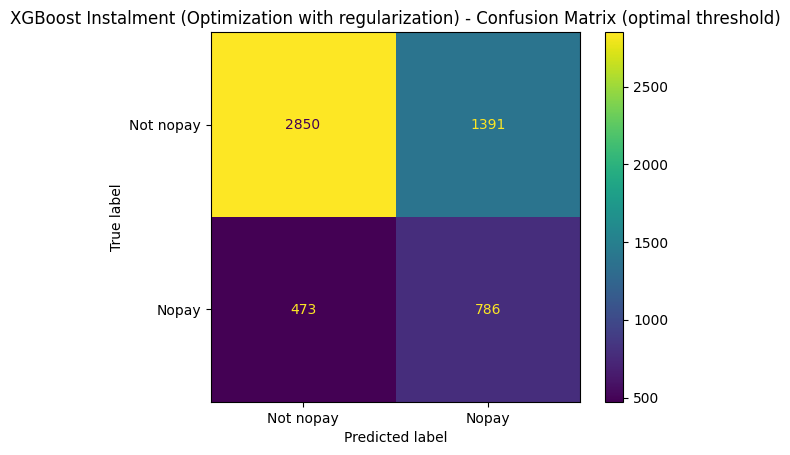

In [ ]:
param_grid = {
    'n_estimators': [100, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.7, 1],
    'colsample_bytree': [0.7, 1],
    'scale_pos_weight': [1, len(y_train) / sum(y_train)],
    'reg_alpha': [0, 0.1, 1],   #lasso
    'reg_lambda': [1, 5, 10]    #ridge
}

grid = GridSearchCV(XGBClassifier(use_label_encoder=False, eval_metric='auc'), param_grid,scoring='f1', cv=3, verbose=1, n_jobs=-1)
grid.fit(X_train, y_train)
best_xgb = grid.best_estimator_

evaluate_metrics(best_xgb, X_test, y_test, model_name='XGBoost Instalment (Optimization with regularization)')

In [87]:
grid.best_params_

{'colsample_bytree': 1,
 'learning_rate': 0.1,
 'max_depth': 3,
 'n_estimators': 300,
 'reg_alpha': 1,
 'reg_lambda': 10,
 'scale_pos_weight': 4.367937372362151,
 'subsample': 0.7}

Fitting 3 folds for each of 1296 candidates, totalling 3888 fits


C:\Users\gergo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
C:\Users\gergo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:158: UserWarning: [18:24:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Evaluation results for: XGBoost NoInstalment (Optimization with regularization)
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.78      0.83      5237
           1       0.37      0.57      0.45      1178

    accuracy                           0.74      6415
   macro avg       0.63      0.68      0.64      6415
weighted avg       0.79      0.74      0.76      6415

ROC AUC Score: 0.7557129903361643
F1 Score: 0.44928021426180115
Precision: 0.37092316196793806
Recall: 0.5696095076400679
Best threshold (F1 optimalized): 0.53


<Figure size 800x500 with 0 Axes>

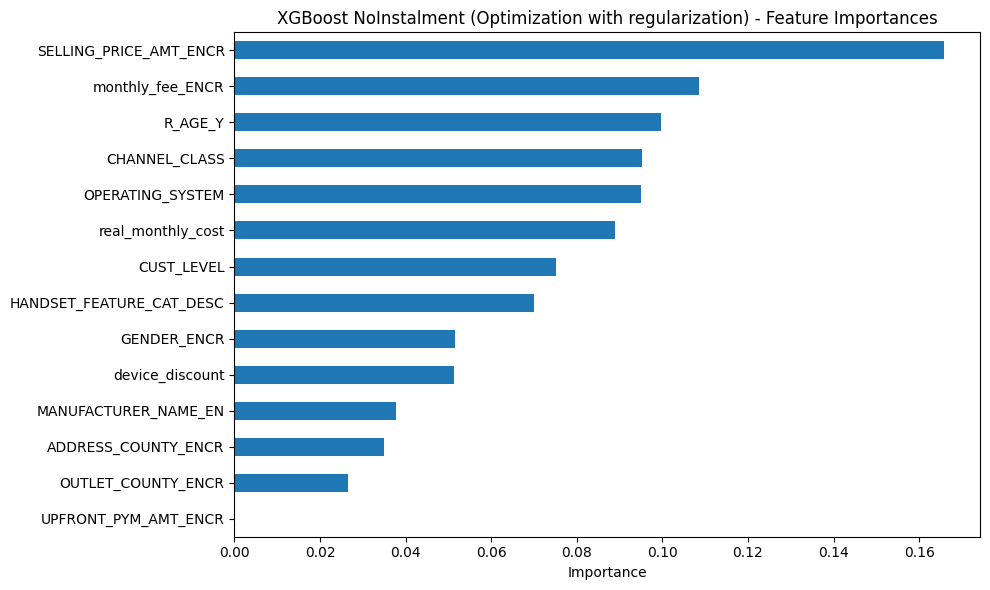

In [89]:
param_grid = {
    'n_estimators': [100, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.7, 1],
    'colsample_bytree': [0.7, 1],
    'scale_pos_weight': [1, len(y_train) / sum(y_train)],
    'reg_alpha': [0, 0.1, 1],   #lasso
    'reg_lambda': [1, 5, 10]    #ridge
}

grid = GridSearchCV(XGBClassifier(use_label_encoder=False, eval_metric='auc'), param_grid,scoring='f1', cv=3, verbose=1, n_jobs=-1)
grid.fit(X_train_non, y_train_non)
best_xgb_non = grid.best_estimator_

evaluate_metrics(best_xgb_non, X_test_non, y_test_non, model_name='XGBoost NoInstalment (Optimization with regularization)')

In [90]:
grid.best_params_

{'colsample_bytree': 0.7,
 'learning_rate': 0.01,
 'max_depth': 7,
 'n_estimators': 100,
 'reg_alpha': 1,
 'reg_lambda': 1,
 'scale_pos_weight': 4.367937372362151,
 'subsample': 0.7}

Text(0.5, 1.0, 'Correlation heatmap Instalment')

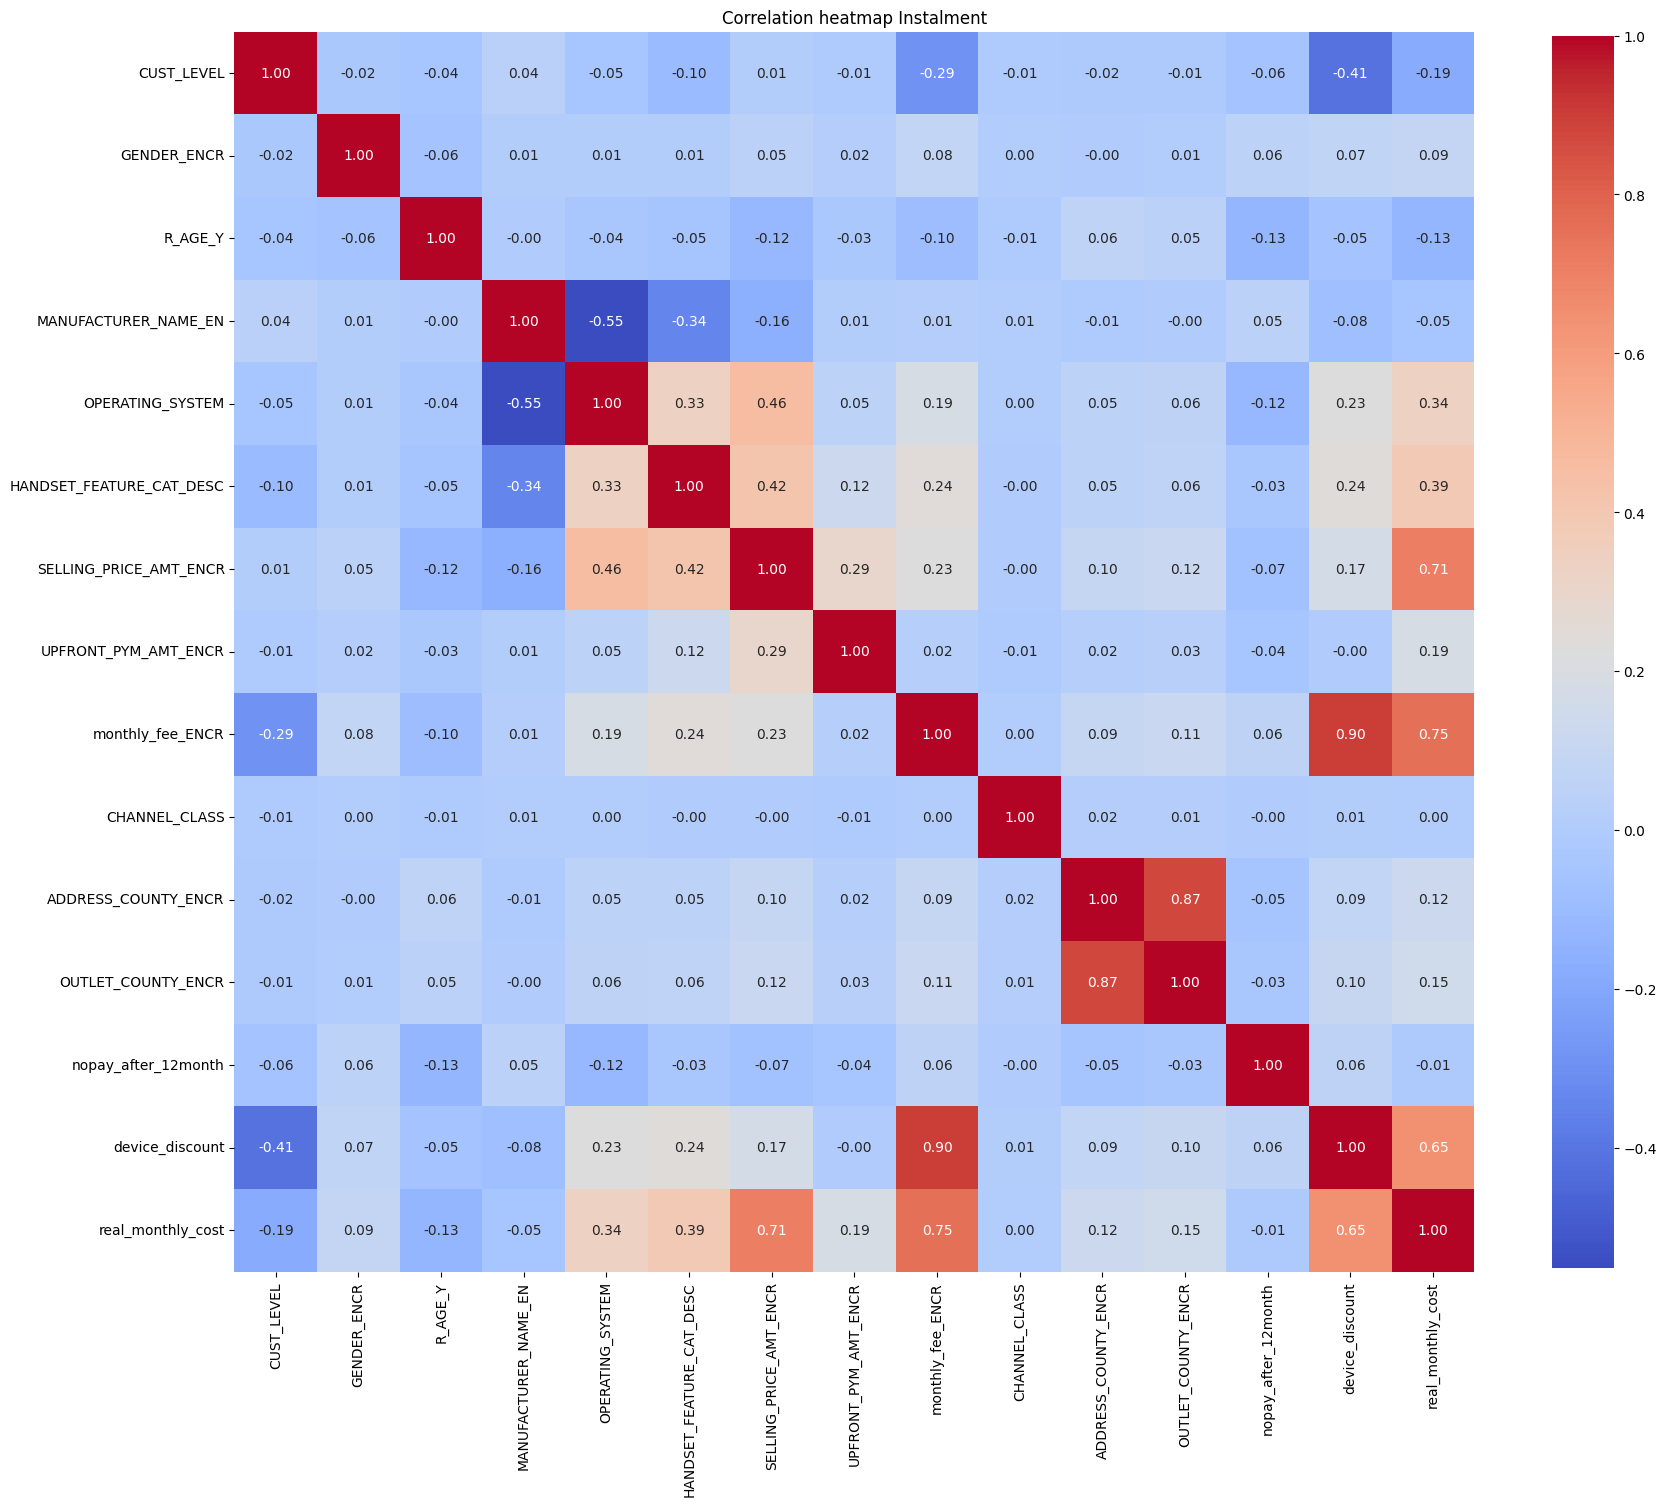

In [96]:
corr = df_segmented.corr()
plt.figure(figsize=(20, 20))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', square=True, cbar_kws={'shrink': .8})
plt.title('Correlation heatmap Instalment')

Text(0.5, 1.0, 'Correlation heatmap NoInstalment')

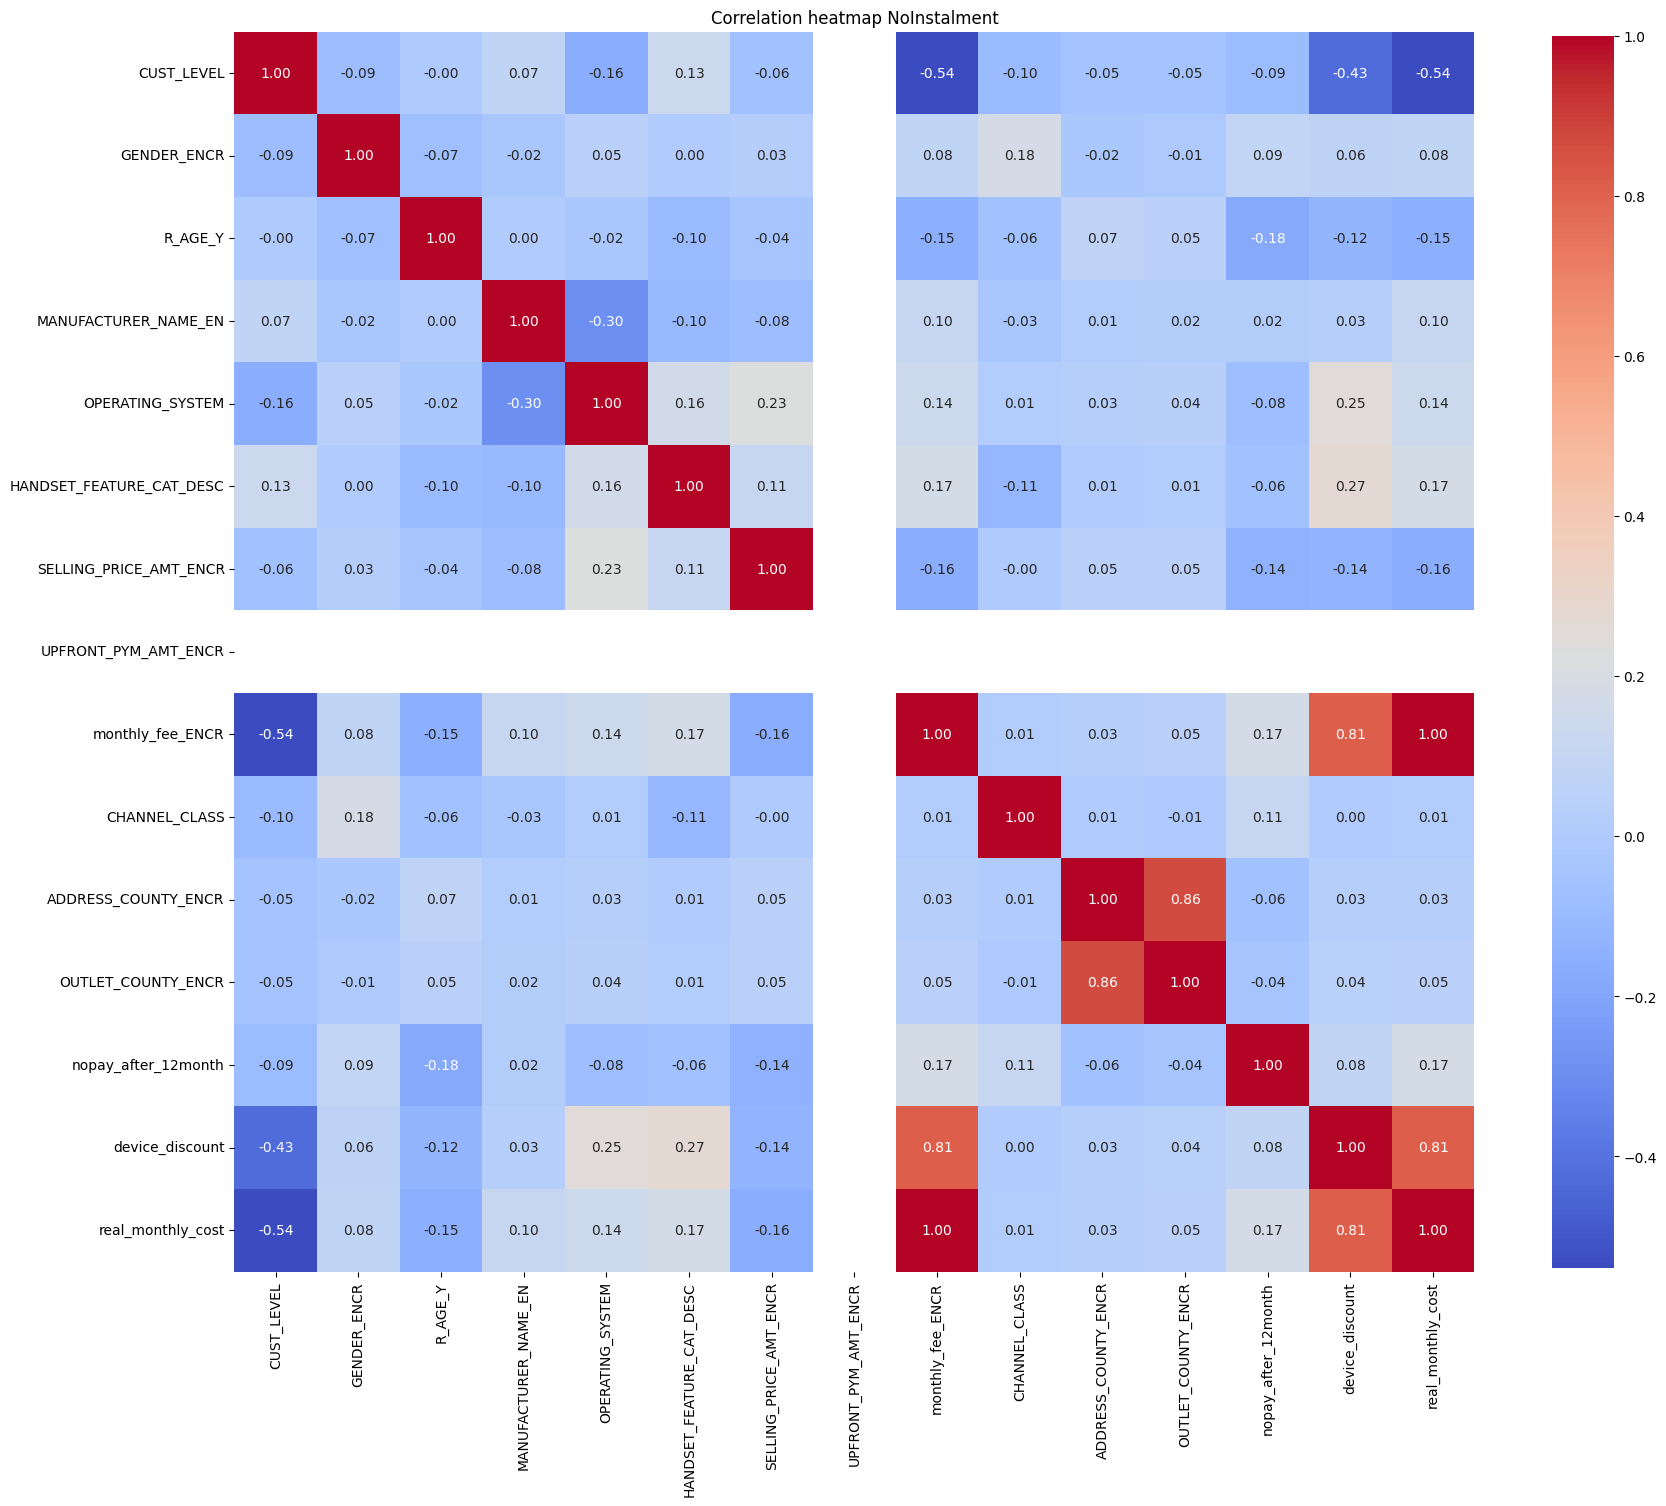

In [97]:
corr = df_non_inst.corr()
plt.figure(figsize=(20, 20))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', square=True, cbar_kws={'shrink': .8})
plt.title('Correlation heatmap NoInstalment')

In [100]:
import shap
def plot_shap_summary(model, X_test, title):
    explainer = shap.Explainer(model)
    shap_values = explainer(X_test)

    plt.title(title)
    shap.plots.beeswarm(shap_values, show=False)
    plt.tight_layout()
    plt.show()

C:\Users\gergo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


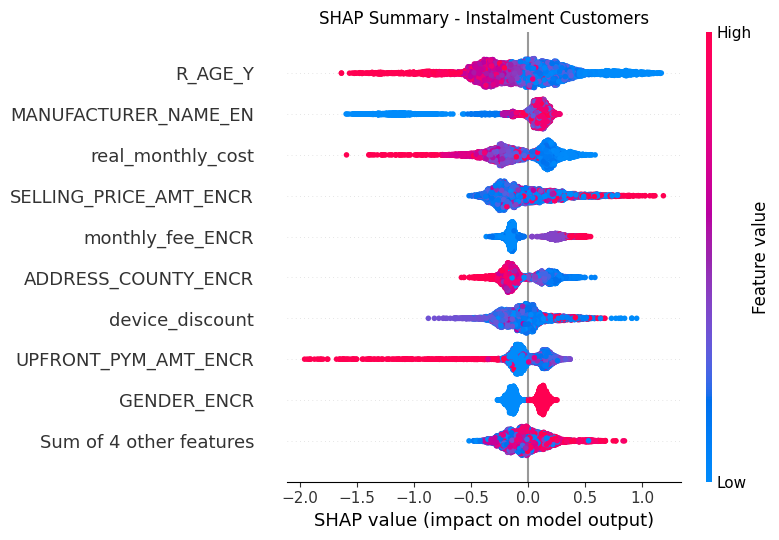

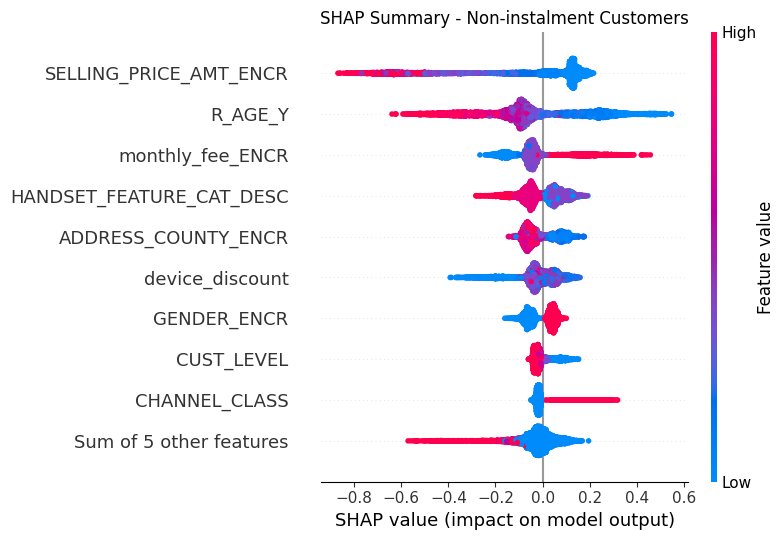

In [101]:
plot_shap_summary(best_xgb, X_test, "SHAP Summary - Instalment Customers")
plot_shap_summary(best_xgb_non, X_test_non, "SHAP Summary - Non-instalment Customers")

Models3.0

In [134]:
df_2.head()

DAY_ID_ENCR  CUST_LEVEL  GENDER_ENCR  R_AGE_Y  INSTALMENT_IND  INSTAL_CNT  \
0  2016-05-22           1            1       19               0           0   
1  2016-05-12           3            1       24               1          17   
2  2015-11-20           3            0       29               0           0   
3  2016-05-07           2            0       58               1          22   
4  2016-04-07           2            0       31               1           6   

   MANUFACTURER_NAME_EN  OPERATING_SYSTEM  HANDSET_FEATURE_CAT_DESC  \
0                     2                 0                         5   
1                     7                 0                         8   
2                     4                 0                         7   
3                     1                 6                         8   
4                     7                 0                         7   

   MOVING_AVERAGE_PRICE_AMT_ENCR  SELLING_PRICE_AMT_ENCR  \
0                        3026.43                    0.00   
1                       25228.71                21371.14   
2                        4244.00                    0.00   
3                       15082.86                11247.43   
4                        5305.71                 5060.71   

   UPFRONT_PYM_AMT_ENCR  monthly_fee_ENCR  TARIFF_LEVEL  CHANNEL_CLASS  \
0                  0.00            448.82             3              1   
1               1187.29            730.03             2              0   
2                  0.00            730.03             2              0   
3                  0.00            246.34             4              0   
4                421.71            246.34             4              0   

   channel_group  ADDRESS_COUNTY_ENCR  OUTLET_COUNTY_ENCR  \
0              3                   11                  11   
1              2                   12                   1   
2              2                   16                  16   
3              0                   10                  10   
4              0                    4                  15   

   FRAUD_STATUS_6MONTH  nopay_after_12month  
0                    0                    0  
1                    1                    1  
2                    0                    0  
3                    0                    0  
4                    0                    0

In [ ]:
df_2['device_discount'] = df_2['MOVING_AVERAGE_PRICE_AMT_ENCR'] - df_2['SELLING_PRICE_AMT_ENCR']
cols_to_drop = [
    'MOVING_AVERAGE_PRICE_AMT_ENCR',
    'DAY_ID_ENCR',
    'channel_group',
    'FRAUD_STATUS_6MONTH'
]
df_2.drop(columns=cols_to_drop, inplace=True, errors='ignore')


In [141]:
df_2_inst = df_2[df_2['INSTALMENT_IND'] == 1].copy()
df_2_inst = df_2_inst.drop('INSTALMENT_IND', axis=1)

df_2_non_inst = df_2[df_2['INSTALMENT_IND'] == 0].copy()
df_2_non_inst = df_2_non_inst.drop('INSTALMENT_IND', axis=1)

Text(0.5, 1.0, 'Correlation heatmap Instalment')

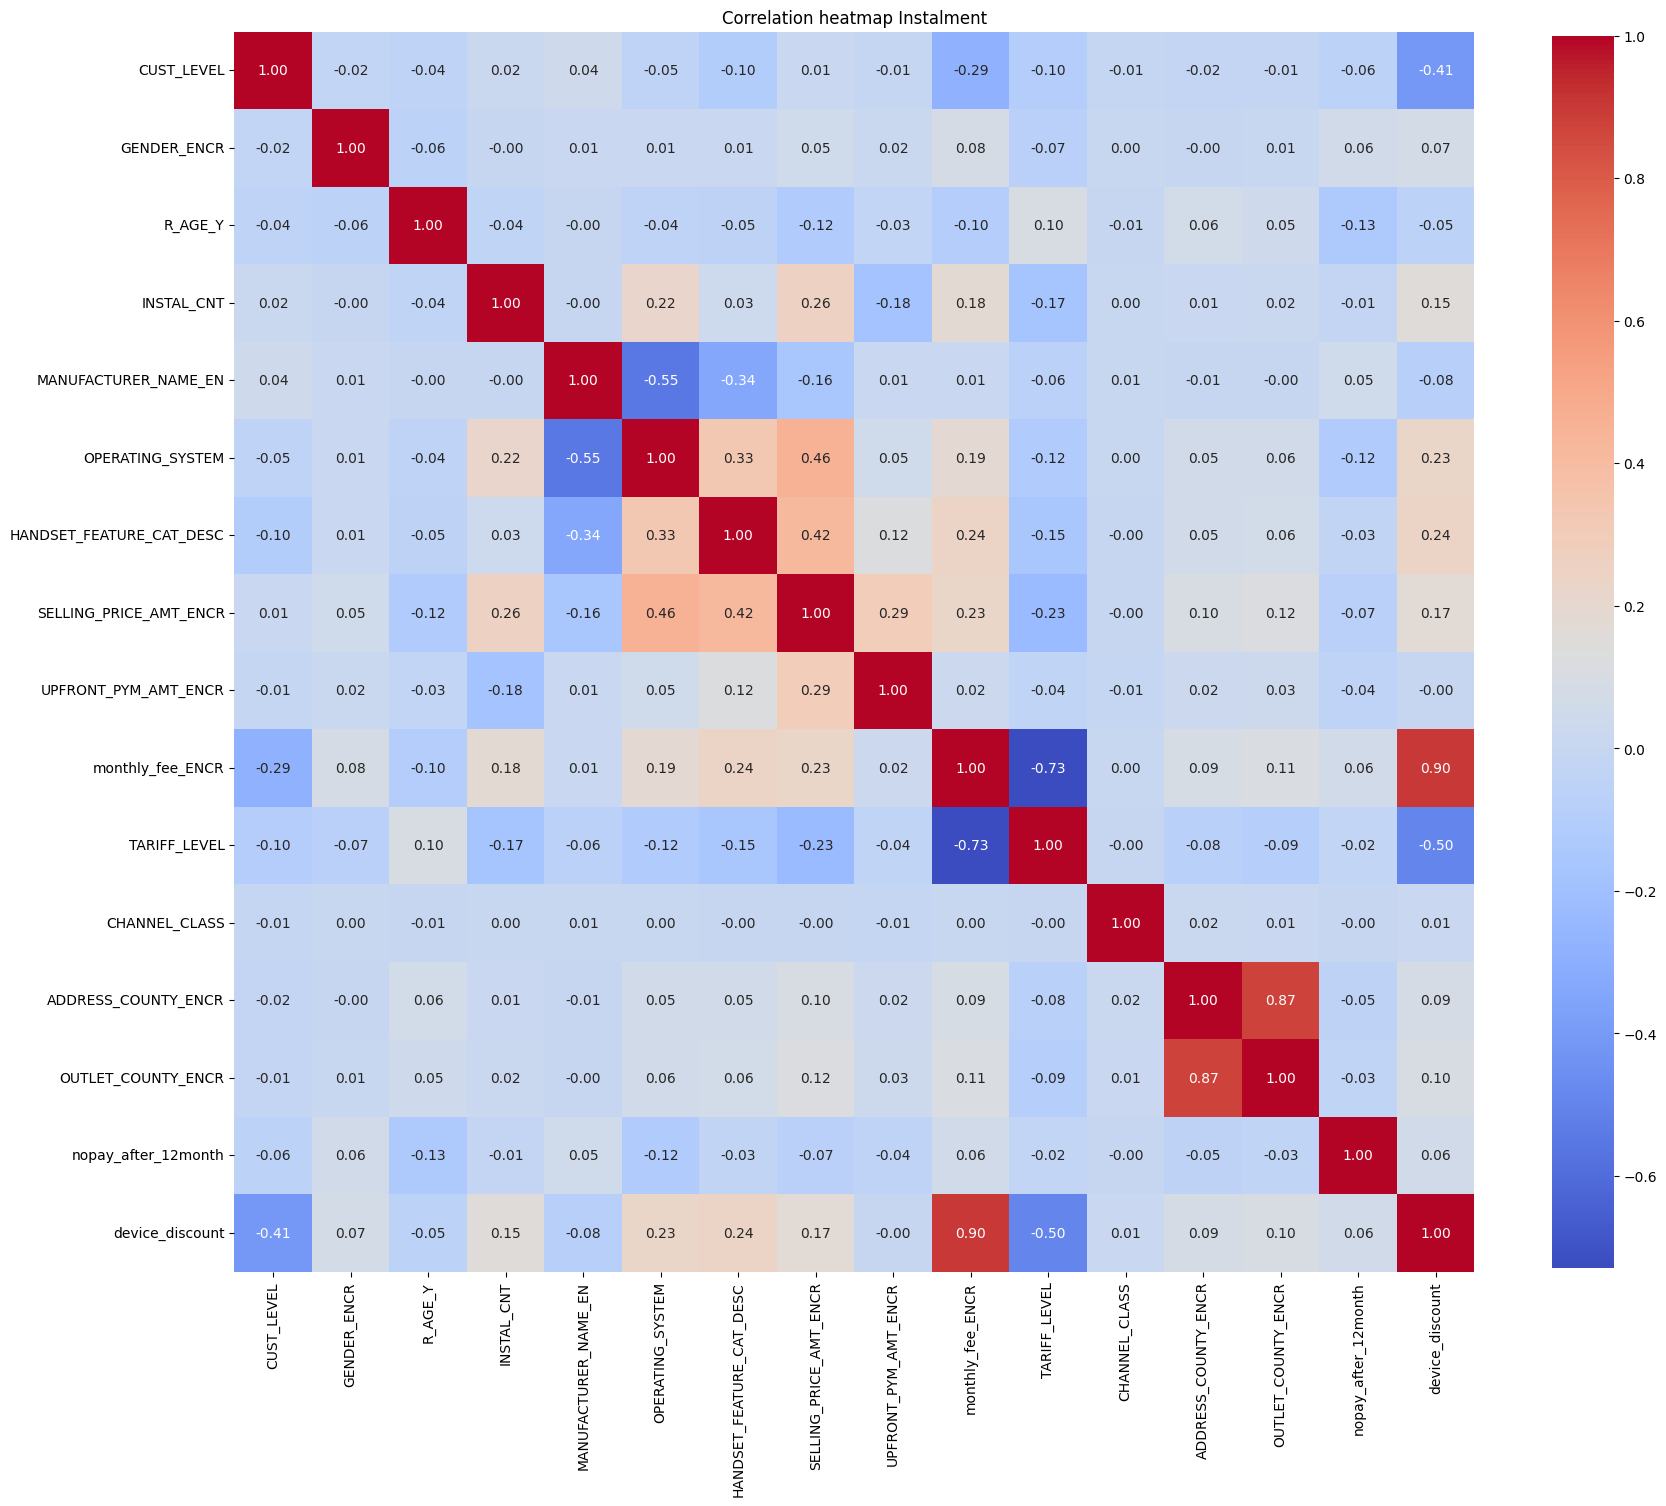

In [144]:
corr = df_2_inst.corr()
plt.figure(figsize=(20, 20))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', square=True, cbar_kws={'shrink': .8})
plt.title('Correlation heatmap Instalment')

In [145]:
cols_to_drop = [
    'monthly_fee_ENCR',
    'OUTLET_COUNTRY_ENCR'
]
df_2_inst.drop(columns=cols_to_drop, inplace=True, errors='ignore')

Text(0.5, 1.0, 'Correlation heatmap NoInstalment')

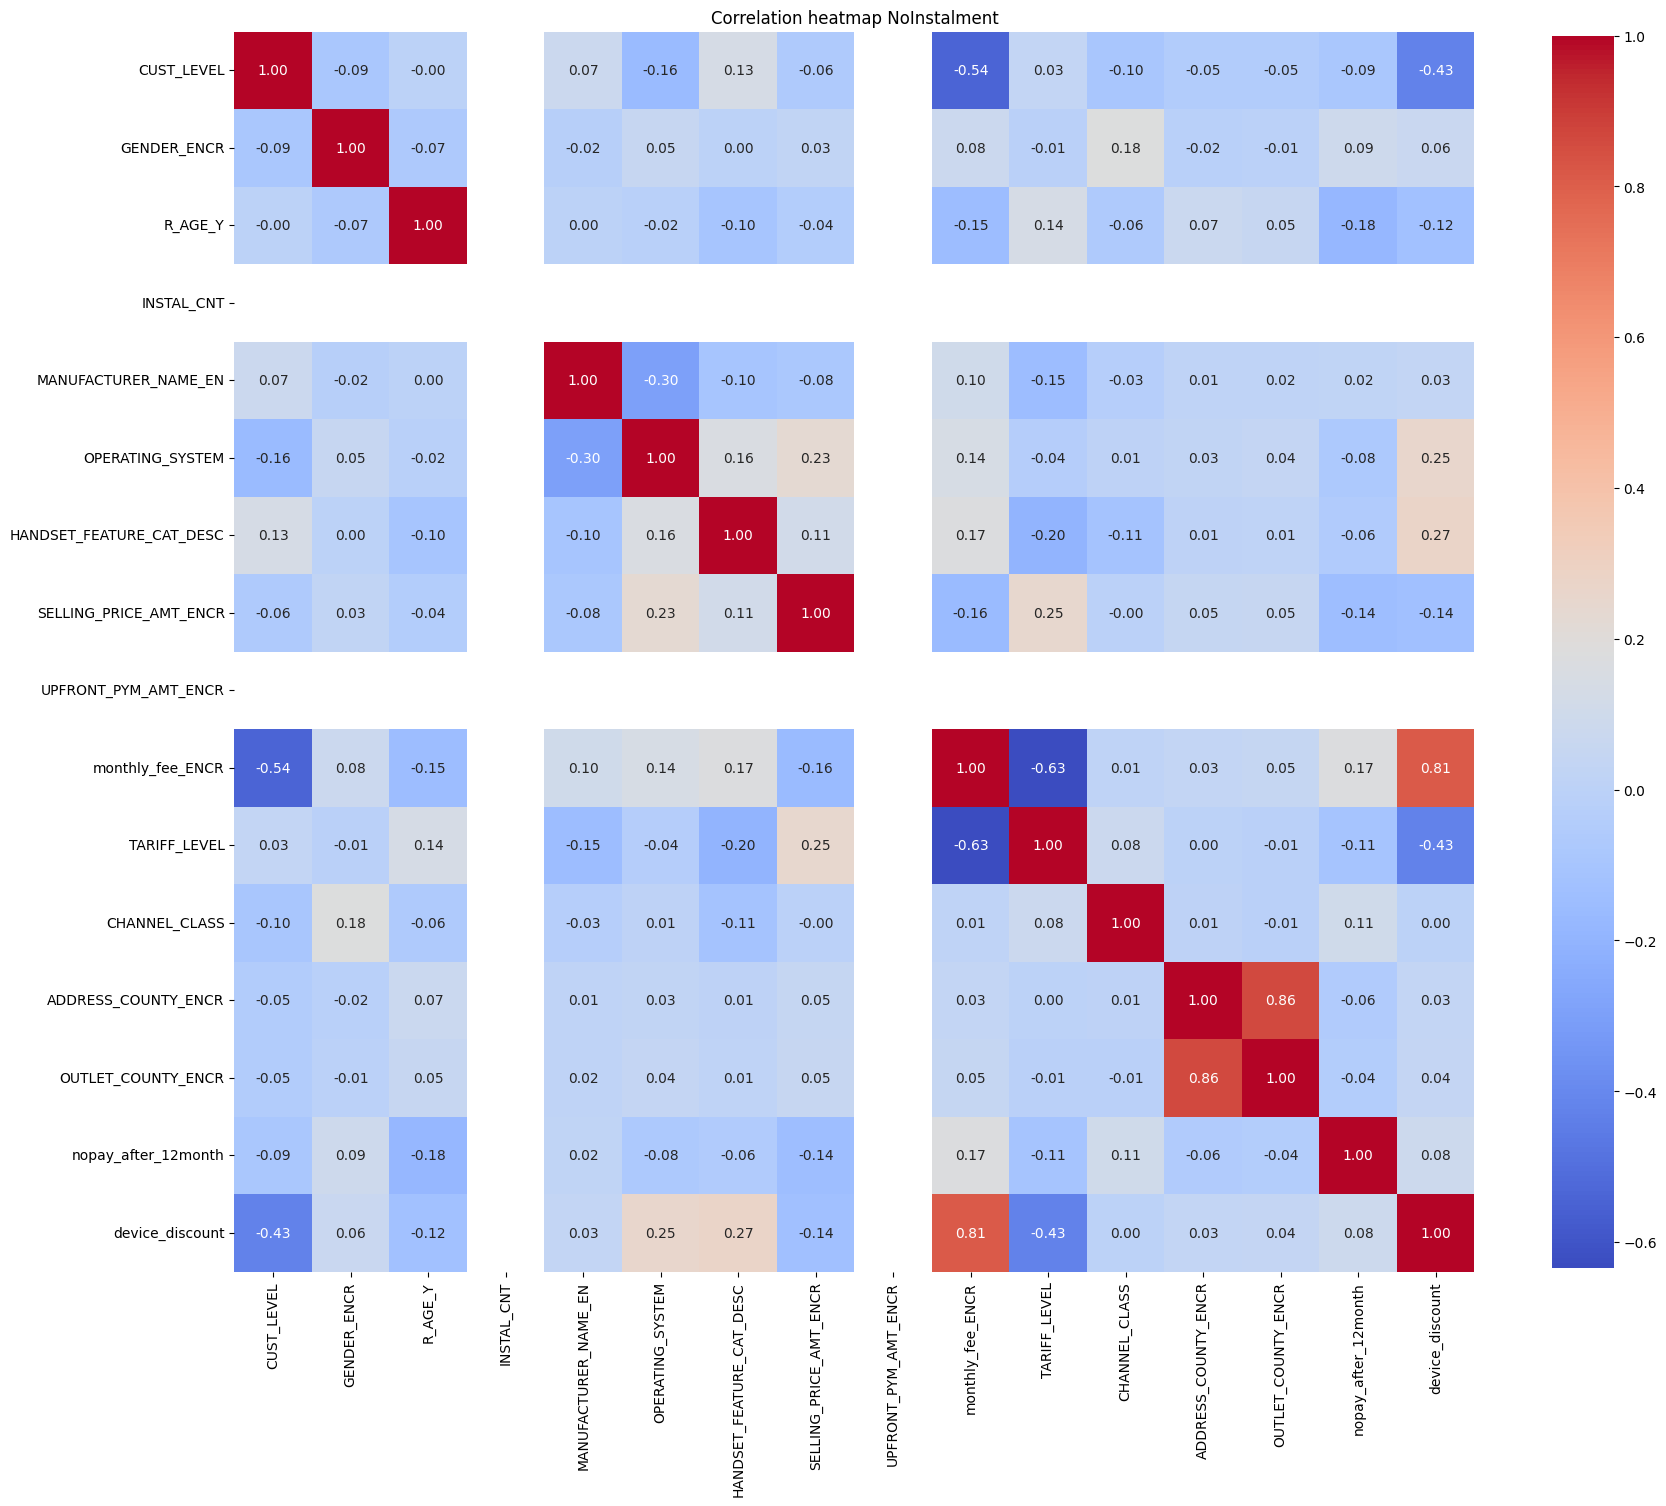

In [143]:
corr = df_2_non_inst.corr()
plt.figure(figsize=(20, 20))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', square=True, cbar_kws={'shrink': .8})
plt.title('Correlation heatmap NoInstalment')

In [146]:
cols_to_drop = [
    'INSTAL_CNT',
    'UPFRONT_PYM_AMT_ENCR',
    'monthly_fee_ENCR',
    'OUTLET_COUNTRY_ENCR'
]
df_2_non_inst.drop(columns=cols_to_drop, inplace=True, errors='ignore')

In [148]:
X = df_2_inst.drop(columns=['nopay_after_12month'])
y = df_2_inst['nopay_after_12month']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)

In [149]:
X_non = df_2_non_inst.drop(columns=['nopay_after_12month'])
y_non = df_2_non_inst['nopay_after_12month']
X_train_non, X_test_non, y_train_non, y_test_non = train_test_split(X_non, y_non, stratify=y_non, test_size=0.3, random_state=42)

Fitting 3 folds for each of 1296 candidates, totalling 3888 fits


C:\Users\gergo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:158: UserWarning: [19:02:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Evaluation results for: XGBoost Instalment (Optimization with regularization)
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.63      0.73      4241
           1       0.35      0.67      0.46      1259

    accuracy                           0.64      5500
   macro avg       0.61      0.65      0.60      5500
weighted avg       0.75      0.64      0.67      5500

ROC AUC Score: 0.7080673945985508
F1 Score: 0.4606956998082717
Precision: 0.3515886287625418
Recall: 0.6679904686258936
Best threshold (F1 optimalized): 0.54


<Figure size 800x500 with 0 Axes>

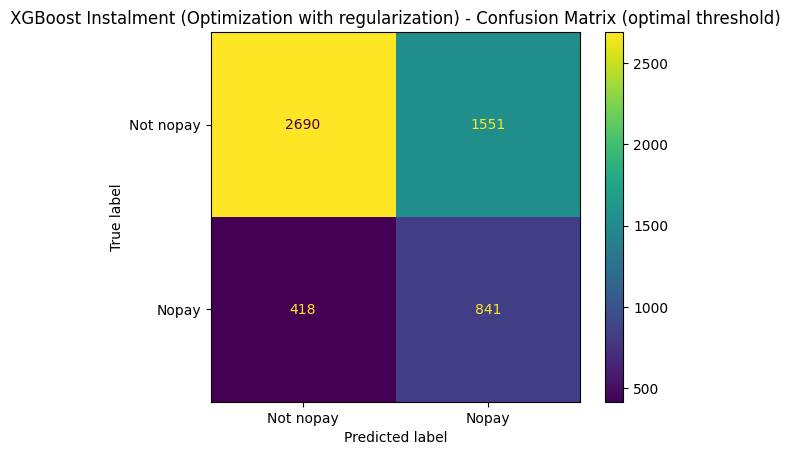

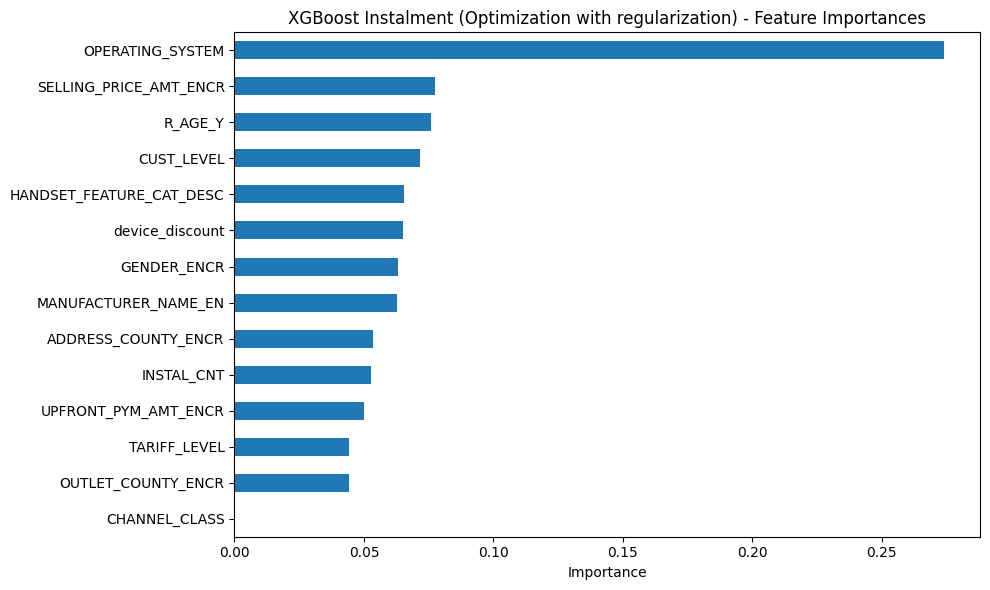

In [150]:
param_grid = {
    'n_estimators': [100, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.7, 1],
    'colsample_bytree': [0.7, 1],
    'scale_pos_weight': [1, len(y_train) / sum(y_train)],
    'reg_alpha': [0, 0.1, 1],   #lasso
    'reg_lambda': [1, 5, 10]    #ridge
}

grid = GridSearchCV(XGBClassifier(use_label_encoder=False, eval_metric='auc'), param_grid,scoring='f1', cv=3, verbose=1, n_jobs=-1)
grid.fit(X_train, y_train)
best_xgb = grid.best_estimator_

evaluate_metrics(best_xgb, X_test, y_test, model_name='XGBoost Instalment (Optimization with regularization)')

In [151]:
grid.best_params_

{'colsample_bytree': 1,
 'learning_rate': 0.2,
 'max_depth': 3,
 'n_estimators': 100,
 'reg_alpha': 0,
 'reg_lambda': 10,
 'scale_pos_weight': 4.367937372362151,
 'subsample': 0.7}

Fitting 3 folds for each of 1296 candidates, totalling 3888 fits


C:\Users\gergo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:158: UserWarning: [19:09:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Evaluation results for: XGBoost NoInstalment (Optimization with regularization)
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.79      0.84      5237
           1       0.37      0.55      0.45      1178

    accuracy                           0.75      6415
   macro avg       0.63      0.67      0.64      6415
weighted avg       0.79      0.75      0.77      6415

ROC AUC Score: 0.7546721723092804
F1 Score: 0.4452856159669649
Precision: 0.3744212962962963
Recall: 0.5492359932088285
Best threshold (F1 optimalized): 0.59


<Figure size 800x500 with 0 Axes>

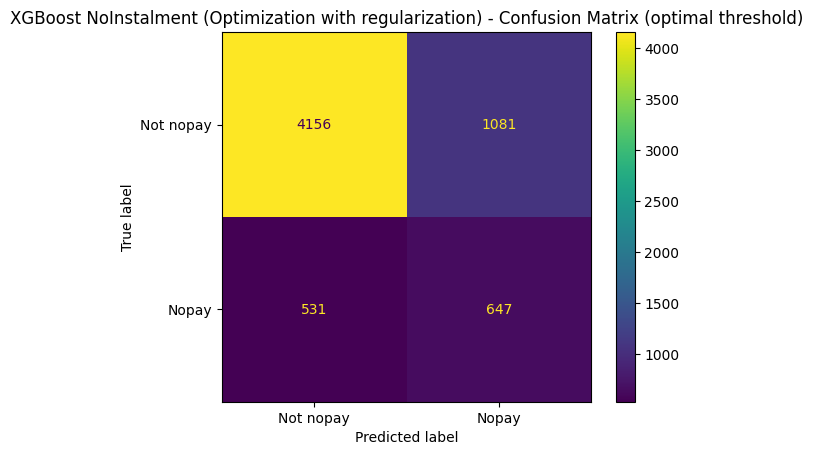

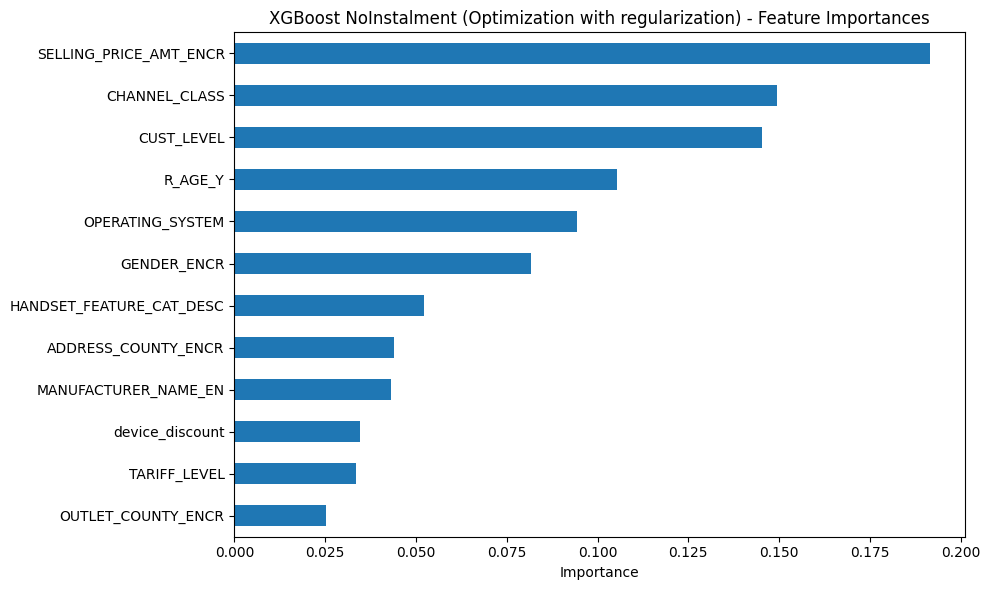

In [152]:
param_grid = {
    'n_estimators': [100, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.7, 1],
    'colsample_bytree': [0.7, 1],
    'scale_pos_weight': [1, len(y_train) / sum(y_train)],
    'reg_alpha': [0, 0.1, 1],   #lasso
    'reg_lambda': [1, 5, 10]    #ridge
}

grid = GridSearchCV(XGBClassifier(use_label_encoder=False, eval_metric='auc'), param_grid,scoring='f1', cv=3, verbose=1, n_jobs=-1)
grid.fit(X_train_non, y_train_non)
best_xgb_non = grid.best_estimator_

evaluate_metrics(best_xgb_non, X_test_non, y_test_non, model_name='XGBoost NoInstalment (Optimization with regularization)')